# Inference Script - Load Checkpoints and Run Predictions

In [54]:
import os
import json
import pickle
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from pathlib import Path
from transformers import CLIPProcessor, CLIPModel
from torchvision import transforms

# Suppress tokenizer warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"

class MLPClassifier(nn.Module):
    """Simple multi-layer perceptron used for Stage 1 classifier heads."""

    def __init__(self, input_dim, num_classes, hidden_dims, dropout=0.3):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.classifier = nn.Sequential(*layers)

    def forward(self, x):
        return self.classifier(x)

def load_models(checkpoint_dir='classification_results/checkpoints',
                stage1_dir='classification_results/stage1_classifiers',
                device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Load saved lightweight classifiers (traditional + Stage 1 MLPs).
    """
    models = {}

    # Load metadata (few-shot experiments)
    metadata_path = os.path.join(checkpoint_dir, 'metadata.pkl')
    if not os.path.exists(metadata_path):
        raise FileNotFoundError(f"Missing metadata.pkl in {checkpoint_dir}")
    with open(metadata_path, 'rb') as f:
        metadata = pickle.load(f)
    models['metadata'] = metadata

    # Load KNN models
    knn_clip_path = os.path.join(checkpoint_dir, 'knn_clip.pkl')
    if os.path.exists(knn_clip_path):
        with open(knn_clip_path, 'rb') as f:
            models['knn_clip'] = pickle.load(f)

    knn_dino_path = os.path.join(checkpoint_dir, 'knn_dino.pkl')
    if os.path.exists(knn_dino_path):
        with open(knn_dino_path, 'rb') as f:
            models['knn_dino'] = pickle.load(f)

    # Load Linear Probe models
    lr_clip_path = os.path.join(checkpoint_dir, 'lr_clip.pkl')
    if os.path.exists(lr_clip_path):
        with open(lr_clip_path, 'rb') as f:
            models['lr_clip'] = pickle.load(f)

    lr_dino_path = os.path.join(checkpoint_dir, 'lr_dino.pkl')
    if os.path.exists(lr_dino_path):
        with open(lr_dino_path, 'rb') as f:
            models['lr_dino'] = pickle.load(f)

    # Load Stage 1 MLP classifiers if available
    torch_device = device if isinstance(device, torch.device) else torch.device(device)
    stage1_models = {}
    stage1_metadata_path = os.path.join(stage1_dir, 'stage1_metadata.json')
    if os.path.exists(stage1_metadata_path):
        with open(stage1_metadata_path, 'r') as f:
            stage1_metadata = json.load(f)
        models['stage1_metadata'] = stage1_metadata
        stage1_config = stage1_metadata.get('config', {})
        hidden_dim_map = stage1_config.get('hidden_dims', {})
        dropout = stage1_config.get('dropout', 0.3)
        clip_dim = stage1_metadata.get('clip_feature_dim')
        dino_dim = stage1_metadata.get('dino_feature_dim')
        num_classes = stage1_metadata.get('num_classes')
        for model_name in stage1_metadata.get('models', []):
            checkpoint_path = os.path.join(stage1_dir, f'{model_name}.pth')
            if not os.path.exists(checkpoint_path):
                continue
            suffix = model_name.split('_', 1)[1] if '_' in model_name else model_name
            hidden_dims = hidden_dim_map.get(suffix, [])
            input_dim = clip_dim if model_name.startswith('clip_') else dino_dim
            mlp = MLPClassifier(input_dim, num_classes, hidden_dims, dropout=dropout)
            state = torch.load(checkpoint_path, map_location=torch_device)
            state_dict = state.get('model_state_dict', state)
            mlp.load_state_dict(state_dict)
            mlp = mlp.to(torch_device)
            mlp.eval()
            stage1_models[model_name] = mlp
        if stage1_models:
            models['stage1_models'] = stage1_models

    base_keys = [k for k in models.keys() if k not in {'metadata', 'stage1_metadata', 'stage1_models'}]
    print(f"✓ Loaded models from {checkpoint_dir}")
    print(f"  - Classes: {len(metadata['classes'])}")
    print(f"  - Available classic heads: {base_keys}")
    if stage1_models:
        print(f"  - Loaded {len(stage1_models)} Stage 1 MLP heads from {stage1_dir}")

    return models

def load_feature_extractors(device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Load CLIP and DINOv2 feature extractors.
    """
    print(f"Loading feature extractors on {device}...")

    # Load CLIP
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    clip_model.eval()
    print("✓ CLIP loaded")

    # Load DINOv2
    dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
    dinov2_model.eval()

    dinov2_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    print("✓ DINOv2 loaded")

    return clip_model, clip_processor, dinov2_model, dinov2_transform

def extract_clip_features(image_paths, clip_model, clip_processor, device='cuda'):
    """
    Extract CLIP features from a list of image paths.
    """
    features = []

    with torch.no_grad():
        for img_path in image_paths:
            image = Image.open(img_path).convert('RGB')
            inputs = clip_processor(images=image, return_tensors="pt").to(device)
            image_features = clip_model.get_image_features(**inputs)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            features.append(image_features.cpu().numpy())

    return np.vstack(features)

def extract_dino_features(image_paths, dinov2_model, dinov2_transform, device='cuda'):
    """
    Extract DINOv2 features from a list of image paths.
    """
    features = []

    with torch.no_grad():
        for img_path in image_paths:
            image = Image.open(img_path).convert('RGB')
            image_tensor = dinov2_transform(image).unsqueeze(0).to(device)
            image_features = dinov2_model(image_tensor)
            features.append(image_features.cpu().numpy())

    return np.vstack(features)

def run_inference(image_paths,
                  checkpoint_dir='classification_results/checkpoints',
                  stage1_dir='classification_results/stage1_classifiers',
                  device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Run inference on a list of images using all available methods.
    """
    image_paths = [str(p) for p in image_paths]
    torch_device = device if isinstance(device, torch.device) else torch.device(device)

    print(f"\n{'='*60}")
    print(f"Running Inference on {len(image_paths)} images")
    print(f"{'='*60}\n")

    # Load models
    models = load_models(checkpoint_dir, stage1_dir, device=torch_device)
    classes = models['metadata']['classes']

    # Load feature extractors
    clip_model, clip_processor, dinov2_model, dinov2_transform = load_feature_extractors(device)

    # Extract features
    print("\nExtracting features...")
    clip_features = extract_clip_features(image_paths, clip_model, clip_processor, device)
    print(f"✓ CLIP features: {clip_features.shape}")

    dino_features = extract_dino_features(image_paths, dinov2_model, dinov2_transform, device)
    print(f"✓ DINOv2 features: {dino_features.shape}")

    results = {
        'image_paths': image_paths,
        'classes': classes,
        'predictions': {}
    }

    print("\nRunning predictions...")

    # CLIP Zero-shot
    print("  - CLIP Zero-shot...", end='')
    text_inputs = clip_processor(
        text=[f"a photo of a {c}" for c in classes],
        return_tensors="pt",
        padding=True
    ).to(device)

    with torch.no_grad():
        text_features = clip_model.get_text_features(**text_inputs)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        clip_features_tensor = torch.from_numpy(clip_features).to(device)
        similarities = clip_features_tensor @ text_features.T
        clip_zeroshot_preds = similarities.argmax(dim=1).cpu().numpy()
    results['predictions']['clip_zeroshot'] = [classes[i] for i in clip_zeroshot_preds]
    print(" Done")

    # KNN predictions
    if 'knn_clip' in models:
        print("  - CLIP + KNN...", end='')
        knn_clip_preds = models['knn_clip'].predict(clip_features)
        results['predictions']['clip_knn'] = [classes[i] for i in knn_clip_preds]
        print(" Done")

    if 'knn_dino' in models:
        print("  - DINOv2 + KNN...", end='')
        knn_dino_preds = models['knn_dino'].predict(dino_features)
        results['predictions']['dino_knn'] = [classes[i] for i in knn_dino_preds]
        print(" Done")

    # Linear Probe predictions
    if 'lr_clip' in models:
        print("  - CLIP + Linear Probe...", end='')
        lr_clip_preds = models['lr_clip'].predict(clip_features)
        results['predictions']['clip_linear'] = [classes[i] for i in lr_clip_preds]
        print(" Done")

    if 'lr_dino' in models:
        print("  - DINOv2 + Linear Probe...", end='')
        lr_dino_preds = models['lr_dino'].predict(dino_features)
        results['predictions']['dino_linear'] = [classes[i] for i in lr_dino_preds]
        print(" Done")

    # Stage 1 MLP predictions
    stage1_models = models.get('stage1_models', {})
    if stage1_models:
        clip_tensor = torch.from_numpy(clip_features).to(torch_device)
        dino_tensor = torch.from_numpy(dino_features).to(torch_device)
        with torch.no_grad():
            print("  - Stage 1 MLP heads:")
            for model_name, mlp in stage1_models.items():
                if model_name.startswith('clip_'):
                    logits = mlp(clip_tensor)
                else:
                    logits = mlp(dino_tensor)
                preds = logits.argmax(dim=1).cpu().numpy()
                results['predictions'][model_name] = [classes[i] for i in preds]
                print(f"      • {model_name} (Done)")

    return results

def print_results(results):
    """Pretty print inference results."""
    print(f"\n{'='*60}")
    print("INFERENCE RESULTS")
    print(f"{'='*60}\n")

    methods = list(results['predictions'].keys())

    for idx, img_path in enumerate(results['image_paths']):
        print(f"Image {idx+1}: {Path(img_path).name}")
        for method in methods:
            pred = results['predictions'][method][idx]
            print(f"  {method:20s}: {pred}")
        print()

# Example usage:
im = []
for i in os.listdir('balanced_dataset/test/'):
    im.append(str(f'balanced_dataset/test/{i}/'+ os.listdir(f'balanced_dataset/test/{i}')[0]))
image_paths = [
    'balanced_dataset/test/cloudy/train_2396.jpg',
    'balanced_dataset/test/cloudy/train_4448.jpg',
    'balanced_dataset/test/cloudy/train_8158.jpg'
 ]
results = run_inference(im)
print_results(results)

print("Inference script loaded! Use run_inference(image_paths) to run predictions.")


Running Inference on 15 images

✓ Loaded models from classification_results/checkpoints
  - Classes: 15
  - Available classic heads: ['knn_clip', 'knn_dino', 'lr_clip', 'lr_dino']
  - Loaded 6 Stage 1 MLP heads from classification_results/stage1_classifiers
Loading feature extractors on cuda...
✓ CLIP loaded
✓ CLIP loaded


Using cache found in /home/crimson/.cache/torch/hub/facebookresearch_dinov2_main


✓ DINOv2 loaded

Extracting features...
✓ CLIP features: (15, 512)
✓ DINOv2 features: (15, 384)

Running predictions...
  - CLIP Zero-shot... Done
  - CLIP + KNN... Done
  - DINOv2 + KNN... Done
  - CLIP + Linear Probe... Done
  - DINOv2 + Linear Probe... Done
  - Stage 1 MLP heads:
      • clip_1layer (Done)
      • clip_2layer (Done)
      • clip_3layer (Done)
      • dinov2_1layer (Done)
      • dinov2_2layer (Done)
      • dinov2_3layer (Done)

INFERENCE RESULTS

Image 1: d_r_439__jpg.rf.f2f761669f5de691a1cc4590beed9e4e.jpg
  clip_zeroshot       : water
  clip_knn            : Human
  dino_knn            : Human
  clip_linear         : Human
  dino_linear         : Human
  clip_1layer         : Human
  clip_2layer         : Human
  clip_3layer         : Human
  dinov2_1layer       : Human
  dinov2_2layer       : Human
  dinov2_3layer       : Human

Image 2: p (264).jpg
  clip_zeroshot       : pituitary_tumor
  clip_knn            : pituitary_tumor
  dino_knn            : pituitary_

In [ ]:
m = []


In [53]:
m

['balanced_dataset/test/Trash/vid_000045_frame0000039_jpg.rf.5125b0e5a00e44f00573d15570d3b94c.jpg']

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"  # Set to "true" if you want parallelism

# Image Classification Experiments

Now we'll perform zero-shot and few-shot classification on the unified dataset using CLIP and DINOv2 models.

## 1. Install and Import Required Libraries

In [ ]:
!pip install transformers torch torchvision scikit-learn matplotlib seaborn pillow -q

print("Libraries installed successfully!")

In [2]:
import torch
import torch.nn as nn
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# For CLIP
from transformers import CLIPProcessor, CLIPModel

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")

/home/crimson/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!
PyTorch version: 2.9.0+cu128
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4070 Laptop GPU


## 2. Configuration

In [4]:
# Dataset Configuration
DATASET_ROOT = "/home/crimson/Projects/CS6531/muli-2/drone-dataset"
DATASET_NAME = "Drone-Dataset"
import os
# Balanced samples per class
TRAIN_SAMPLES_PER_CLASS = None  # Use all remaining after test and val
VAL_SAMPLES_PER_CLASS = 10    # Validation samples per class
TEST_SAMPLES_PER_CLASS = 10   # Test samples per class

# Few-shot Configuration
N_SHOTS = 50 # Number of training samples per class for few-shot
FEW_SHOT_METHODS = ['knn', 'linear_probe']

# Model Configuration
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Results Configuration
RESULTS_DIR = "classification_results"
SAVE_CONFUSION_MATRIX = True

# Random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"Configuration loaded!")
print(f"Dataset: {DATASET_ROOT}")
print(f"Device: {DEVICE}")
print(f"Balanced split: rest for train, {VAL_SAMPLES_PER_CLASS} val, {TEST_SAMPLES_PER_CLASS} test per class")
print(f"Few-shot samples per class: {N_SHOTS}")

Configuration loaded!
Dataset: /home/crimson/Projects/CS6531/muli-2/drone-dataset
Device: cuda
Balanced split: rest for train, 10 val, 10 test per class
Few-shot samples per class: 50


## 3. Load Dataset

In [5]:
def load_dataset_from_folders(dataset_root):
    """Load dataset from folder structure: {class}/{image}.jpg"""
    root = Path(dataset_root)
    
    # Get all class folders
    classes = sorted([d.name for d in root.iterdir() if d.is_dir()])
    class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
    
    print(f"Found {len(classes)} classes: {classes}")
    
    # Collect all samples
    all_samples = []
    class_counts = {}
    
    for class_name in classes:
        class_path = root / class_name
        images = list(class_path.glob("*.jpg")) + list(class_path.glob("*.png"))
        
        class_counts[class_name] = len(images)
        label = class_to_idx[class_name]
        
        for img_path in images:
            all_samples.append((str(img_path), label))
    
    print(f"\nClass distribution:")
    for class_name, count in sorted(class_counts.items()):
        print(f"  {class_name:25s}: {count:4d} images")
    
    return all_samples, classes, class_to_idx

# Load dataset
print(f"Loading dataset from: {DATASET_ROOT}\n")
all_samples, classes, class_to_idx = load_dataset_from_folders(DATASET_ROOT)

print(f"\nTotal samples: {len(all_samples)}")
print(f"Number of classes: {len(classes)}")

Loading dataset from: /home/crimson/Projects/CS6531/muli-2/drone-dataset

Found 13 classes: ['Agriculture', 'Airport', 'Beach', 'City', 'Desert', 'Forest', 'Grassland', 'Highway', 'Lake', 'Mountain', 'Parking', 'Port', 'Railway']

Class distribution:
  Agriculture              :   79 images
  Airport                  :   63 images
  Beach                    :   63 images
  City                     :  168 images
  Desert                   :   89 images
  Forest                   :   80 images
  Grassland                :   92 images
  Highway                  :   51 images
  Lake                     :   39 images
  Mountain                 :   79 images
  Parking                  :   69 images
  Port                     :   68 images
  Railway                  :   35 images

Total samples: 975
Number of classes: 13


## 4. Split Dataset into Train/Val/Test

In [6]:
# Create balanced split with fixed number of samples per class
def create_balanced_split(all_samples, num_classes, train_per_class, val_per_class, test_per_class):
    """Create balanced train/val/test splits with fixed samples per class
    If train_per_class is None, use all remaining samples after val and test"""
    
    # Group samples by class
    class_samples = {i: [] for i in range(num_classes)}
    for sample in all_samples:
        path, label = sample
        class_samples[label].append(sample)
    
    train_samples = []
    val_samples = []
    test_samples = []
    
    for class_idx in range(num_classes):
        samples = class_samples[class_idx]
        
        # If train_per_class is None, calculate it as remaining after val and test
        if train_per_class is None:
            actual_train_per_class = max(0, len(samples) - val_per_class - test_per_class)
        else:
            actual_train_per_class = train_per_class
        
        total_needed = actual_train_per_class + val_per_class + test_per_class
        
        if len(samples) < val_per_class + test_per_class:
            print(f"Warning: Class {class_idx} ({classes[class_idx]}) has only {len(samples)} samples, needs at least {val_per_class + test_per_class}")
            # Use all available samples
            np.random.shuffle(samples)
            n_test = min(len(samples), test_per_class)
            n_val = min(len(samples) - n_test, val_per_class)
            n_train = len(samples) - n_test - n_val
            
            test_samples.extend(samples[:n_test])
            val_samples.extend(samples[n_test:n_test+n_val])
            train_samples.extend(samples[n_test+n_val:])
        else:
            # Randomly select samples
            np.random.shuffle(samples)
            test_samples.extend(samples[:test_per_class])
            val_samples.extend(samples[test_per_class:test_per_class+val_per_class])
            
            if train_per_class is None:
                # Use all remaining samples for training
                train_samples.extend(samples[test_per_class+val_per_class:])
            else:
                train_samples.extend(samples[test_per_class+val_per_class:test_per_class+val_per_class+actual_train_per_class])
    
    return train_samples, val_samples, test_samples

print("Creating balanced splits...")
train_samples, val_samples, test_samples = create_balanced_split(
    all_samples, len(classes), 
    TRAIN_SAMPLES_PER_CLASS,  # None = use all remaining
    VAL_SAMPLES_PER_CLASS, 
    TEST_SAMPLES_PER_CLASS
)

print(f"\nBalanced dataset split:")
print(f"  Train: {len(train_samples)} samples ({len(train_samples)//len(classes)} per class × {len(classes)} classes)")
print(f"  Val:   {len(val_samples)} samples ({VAL_SAMPLES_PER_CLASS} per class × {len(classes)} classes)")
print(f"  Test:  {len(test_samples)} samples ({TEST_SAMPLES_PER_CLASS} per class × {len(classes)} classes)")

Creating balanced splits...

Balanced dataset split:
  Train: 715 samples (55 per class × 13 classes)
  Val:   130 samples (10 per class × 13 classes)
  Test:  130 samples (10 per class × 13 classes)


## 5. Custom Dataset Class

In [8]:
class ImageDataset(Dataset):
    """Custom dataset for loading images"""
    
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        
        try:
            img = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Warning: Failed to load {img_path}: {e}")
            img = Image.new('RGB', (224, 224), color=0)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

print("Dataset class defined!")

Dataset class defined!


## 6. Load CLIP Model

In [9]:
print("Loading CLIP model...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
clip_model.eval()
print("CLIP model loaded successfully!")

# CLIP preprocessing with data augmentation for training
clip_preprocess_train = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224, padding=8),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], 
                        std=[0.26862954, 0.26130258, 0.27577711]),
])

# CLIP preprocessing without augmentation for validation/test
clip_preprocess_eval = transforms.Compose([
    transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], 
                        std=[0.26862954, 0.26130258, 0.27577711]),
])

print("CLIP preprocessing pipelines created with data augmentation for training!")

Loading CLIP model...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


CLIP model loaded successfully!
CLIP preprocessing pipelines created with data augmentation for training!


## 7. Load DINOv2 Model

In [10]:
print("Loading DINOv2 model...")
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_model = dinov2_model.to(DEVICE)
dinov2_model.eval()
print("DINOv2 model loaded successfully!")

# DINOv2 preprocessing with data augmentation for training
dinov2_transform_train = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# DINOv2 preprocessing without augmentation for validation/test
dinov2_transform_eval = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

print("DINOv2 preprocessing pipelines created with data augmentation for training!")

Loading DINOv2 model...


Using cache found in /home/crimson/.cache/torch/hub/facebookresearch_dinov2_main


DINOv2 model loaded successfully!
DINOv2 preprocessing pipelines created with data augmentation for training!


## 8. Create DataLoaders

In [11]:
# Create datasets for CLIP with augmentation for training
train_dataset_clip = ImageDataset(train_samples, clip_preprocess_train)
val_dataset_clip = ImageDataset(val_samples, clip_preprocess_eval)
test_dataset_clip = ImageDataset(test_samples, clip_preprocess_eval)

# Create datasets for DINOv2 with augmentation for training
train_dataset_dino = ImageDataset(train_samples, dinov2_transform_train)
val_dataset_dino = ImageDataset(val_samples, dinov2_transform_eval)
test_dataset_dino = ImageDataset(test_samples, dinov2_transform_eval)

# Create dataloaders
train_loader_clip = DataLoader(train_dataset_clip, batch_size=BATCH_SIZE, shuffle=True)
val_loader_clip = DataLoader(val_dataset_clip, batch_size=BATCH_SIZE, shuffle=False)
test_loader_clip = DataLoader(test_dataset_clip, batch_size=BATCH_SIZE, shuffle=False)

train_loader_dino = DataLoader(train_dataset_dino, batch_size=BATCH_SIZE, shuffle=True)
val_loader_dino = DataLoader(val_dataset_dino, batch_size=BATCH_SIZE, shuffle=False)
test_loader_dino = DataLoader(test_dataset_dino, batch_size=BATCH_SIZE, shuffle=False)

print(f"DataLoaders created with data augmentation for training!")
print(f"Train: {len(train_dataset_clip)} samples")
print(f"Val: {len(val_dataset_clip)} samples")
print(f"Test: {len(test_dataset_clip)} samples")

DataLoaders created with data augmentation for training!
Train: 715 samples
Val: 130 samples
Test: 130 samples


## 9. Feature Extraction Function

In [12]:
def extract_features(model, dataloader, model_type='clip'):
    """Extract features from a model"""
    features = []
    labels = []
    
    model.eval()
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc=f"Extracting {model_type} features"):
            images = images.to(DEVICE)
            
            if model_type == 'clip':
                image_features = model.get_image_features(pixel_values=images)
                image_features /= image_features.norm(dim=-1, keepdim=True)
            else:  # dinov2
                image_features = model(images)
            
            features.append(image_features.cpu())
            labels.append(targets)
    
    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()
    
    return features, labels

print("Feature extraction function defined!")

Feature extraction function defined!


## 10. Zero-Shot Classification with CLIP

In [13]:
def zero_shot_clip(model, processor, dataloader, classes):
    """Perform zero-shot classification with CLIP"""
    predictions = []
    true_labels = []
    
    # Create text prompts
    text_prompts = [f"a photo of {c.replace('_', ' ').replace('-', ' ')}" for c in classes]
    
    text_inputs = processor(text=text_prompts, return_tensors="pt", padding=True).to(DEVICE)
    
    model.eval()
    with torch.no_grad():
        # Get text features once
        text_features = model.get_text_features(**text_inputs)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        
        for images, labels in tqdm(dataloader, desc="Zero-shot CLIP"):
            images = images.to(DEVICE)
            
            # Extract image features
            image_features = model.get_image_features(pixel_values=images)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            
            # Calculate similarity
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            preds = similarity.argmax(dim=-1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.numpy())
    
    return np.array(predictions), np.array(true_labels)

print("\n" + "="*60)
print("ZERO-SHOT CLASSIFICATION WITH CLIP")
print("="*60)

# Run zero-shot on test set
clip_zero_shot_preds, clip_zero_shot_labels = zero_shot_clip(
    clip_model, clip_processor, test_loader_clip, classes
)
clip_zero_shot_acc = accuracy_score(clip_zero_shot_labels, clip_zero_shot_preds)

print(f"\nCLIP Zero-Shot Test Accuracy: {clip_zero_shot_acc:.4f} ({clip_zero_shot_acc*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(clip_zero_shot_labels, clip_zero_shot_preds, target_names=classes))


ZERO-SHOT CLASSIFICATION WITH CLIP


Zero-shot CLIP: 100%|██████████| 5/5 [00:00<00:00,  5.94it/s]


CLIP Zero-Shot Test Accuracy: 0.6846 (68.46%)

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.80      0.80      0.80        10
     Airport       0.56      0.90      0.69        10
       Beach       1.00      0.90      0.95        10
        City       0.50      0.10      0.17        10
      Desert       0.80      0.80      0.80        10
      Forest       0.89      0.80      0.84        10
   Grassland       1.00      0.60      0.75        10
     Highway       0.88      0.70      0.78        10
        Lake       0.53      0.90      0.67        10
    Mountain       1.00      0.50      0.67        10
     Parking       0.43      1.00      0.61        10
        Port       0.50      0.20      0.29        10
     Railway       0.64      0.70      0.67        10

    accuracy                           0.68       130
   macro avg       0.73      0.68      0.67       130
weighted avg       0.73      0.68      0.67       130



## 11. Create Few-Shot Dataset

In [14]:
def create_few_shot_dataset(samples, n_shots, num_classes):
    """Create a few-shot dataset with n_shots samples per class"""
    few_shot_samples = []
    
    # Group samples by class
    class_samples = {i: [] for i in range(num_classes)}
    for sample in samples:
        path, label = sample
        class_samples[label].append(sample)
    
    # Select n_shots samples from each class
    for class_idx in range(num_classes):
        class_sample_list = class_samples[class_idx]
        if len(class_sample_list) < n_shots:
            print(f"Warning: Class {class_idx} has only {len(class_sample_list)} samples, using all.")
            few_shot_samples.extend(class_sample_list)
        else:
            selected = np.random.choice(len(class_sample_list), n_shots, replace=False)
            few_shot_samples.extend([class_sample_list[i] for i in selected])
    
    return few_shot_samples

# Create few-shot training set
print(f"\nCreating few-shot dataset with {N_SHOTS} samples per class...")
few_shot_samples = create_few_shot_dataset(train_samples, N_SHOTS, len(classes))
print(f"Few-shot dataset created with {len(few_shot_samples)} samples")

# Create few-shot datasets with augmentation for training
few_shot_dataset_clip = ImageDataset(few_shot_samples, clip_preprocess_train)
few_shot_dataset_dino = ImageDataset(few_shot_samples, dinov2_transform_train)

few_shot_loader_clip = DataLoader(few_shot_dataset_clip, batch_size=BATCH_SIZE, shuffle=True)
few_shot_loader_dino = DataLoader(few_shot_dataset_dino, batch_size=BATCH_SIZE, shuffle=True)


Creating few-shot dataset with 50 samples per class...
Few-shot dataset created with 548 samples


## 10.1. Analyze Sample Assignments

In [17]:
import os
from pathlib import Path

# Analyze sample assignments for each split
print("=" * 80)
print("SAMPLE ASSIGNMENT ANALYSIS")
print("=" * 80)

# Create dictionaries to organize samples by class
train_by_class = {class_name: [] for class_name in classes}
val_by_class = {class_name: [] for class_name in classes}
test_by_class = {class_name: [] for class_name in classes}

# Group samples by class
for path, label in train_samples:
    class_name = classes[label]
    filename = os.path.basename(path)
    train_by_class[class_name].append(filename)

for path, label in val_samples:
    class_name = classes[label]
    filename = os.path.basename(path)
    val_by_class[class_name].append(filename)

for path, label in test_samples:
    class_name = classes[label]
    filename = os.path.basename(path)
    test_by_class[class_name].append(filename)

# Display sample assignments per class
for class_name in classes:
    print(f"\n{'=' * 80}")
    print(f"CLASS: {class_name}")
    print(f"{'=' * 80}")
    
    print(f"\nTrain Samples ({len(train_by_class[class_name])} files):")
    for i, filename in enumerate(sorted(train_by_class[class_name])[:10], 1):
        print(f"  {i}. {filename}")
    if len(train_by_class[class_name]) > 10:
        print(f"  ... and {len(train_by_class[class_name]) - 10} more files")
    
    print(f"\nValidation Samples ({len(val_by_class[class_name])} files):")
    for i, filename in enumerate(sorted(val_by_class[class_name])[:10], 1):
        print(f"  {i}. {filename}")
    if len(val_by_class[class_name]) > 10:
        print(f"  ... and {len(val_by_class[class_name]) - 10} more files")
    
    print(f"\nTest Samples ({len(test_by_class[class_name])} files):")
    for i, filename in enumerate(sorted(test_by_class[class_name])[:10], 1):
        print(f"  {i}. {filename}")
    if len(test_by_class[class_name]) > 10:
        print(f"  ... and {len(test_by_class[class_name]) - 10} more files")

# Summary statistics
print(f"\n{'=' * 80}")
print("SUMMARY STATISTICS")
print(f"{'=' * 80}")
print(f"\nTotal Classes: {len(classes)}")
print(f"\nPer-Class Counts:")
print(f"  Train: {TRAIN_SAMPLES_PER_CLASS} samples/class")
print(f"  Validation: {VAL_SAMPLES_PER_CLASS} samples/class")
print(f"  Test: {TEST_SAMPLES_PER_CLASS} samples/class")
print(f"\nTotal Samples:")
print(f"  Train: {len(train_samples)} samples")
print(f"  Validation: {len(val_samples)} samples")
print(f"  Test: {len(test_samples)} samples")
print(f"  Grand Total: {len(train_samples) + len(val_samples) + len(test_samples)} samples")

# Store sample assignments for later use
sample_assignments = {
    'train': train_by_class,
    'val': val_by_class,
    'test': test_by_class
}

print(f"\n✓ Sample assignments stored in 'sample_assignments' dictionary")

SAMPLE ASSIGNMENT ANALYSIS

CLASS: Coral-Reef

Train Samples (50 files):
  1. d_r_419__jpg.rf.178ca6b1ea6a3c639b2558f1b9ea1f75.jpg
  2. d_r_455__jpg.rf.c52658b911e3c9580348f8b8635b457c.jpg
  3. d_r_467__jpg.rf.22b2b6b1843439720b59841931c1b26f.jpg
  4. d_r_519__jpg.rf.4b343d750ca55aea26d62af82dfec0b6.jpg
  5. d_r_606__jpg.rf.86cc4e854e1d2d2f58c7b4b15856beb5.jpg
  6. f_r_111__jpg.rf.8c00348147e2e12492e63a411eae2e94.jpg
  7. f_r_115__jpg.rf.1a2bc95bd9eb0394af36b7a5bdcc7552.jpg
  8. f_r_119__jpg.rf.60e667f33eb64a6607807f69ecd07cc1.jpg
  9. f_r_147__jpg.rf.7a39f61c6071c9df96de3eed79032db4.jpg
  10. f_r_1556__jpg.rf.06b3cb6314857ca4be357f1379028d0b.jpg
  ... and 40 more files

Validation Samples (20 files):
  1. d_r_542__jpg.rf.d08cabcb20de7861131ecfe01d2aae50.jpg
  2. f_r_123__jpg.rf.a945ec4d9e8f5a80af3a71463065e1cb.jpg
  3. f_r_154__jpg.rf.3635425c637c9e3b3172635314e27591.jpg
  4. f_r_157__jpg.rf.d8911146e63ee8d60cd5217a8813627f.jpg
  5. f_r_180__jpg.rf.06ef4790b5929943904175a7af4a0c62.jpg

## 10.2. Save Balanced Dataset

In [ ]:
import shutil
import json
import zipfile
from pathlib import Path

# Create output directory for balanced dataset
output_root = "balanced_dataset"
print(f"Creating balanced dataset at: {output_root}")
print("=" * 80)

# Create directory structure
for split in ['train', 'val', 'test']:
    for class_name in classes:
        split_class_dir = os.path.join(output_root, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

print(f"✓ Created directory structure with {len(classes)} classes for 3 splits")

# Copy files to balanced dataset
def copy_samples_to_split(samples, split_name):
    """Copy samples to the appropriate split directory"""
    copied_count = 0
    for path, label in samples:
        class_name = classes[label]
        filename = os.path.basename(path)
        
        # Source and destination paths
        src_path = path
        dst_path = os.path.join(output_root, split_name, class_name, filename)
        
        # Copy file
        shutil.copy2(src_path, dst_path)
        copied_count += 1
    
    return copied_count

# Copy all splits
print("\nCopying files...")
train_count = copy_samples_to_split(train_samples, 'train')
print(f"✓ Copied {train_count} training samples")

val_count = copy_samples_to_split(val_samples, 'val')
print(f"✓ Copied {val_count} validation samples")

test_count = copy_samples_to_split(test_samples, 'test')
print(f"✓ Copied {test_count} test samples")

total_copied = train_count + val_count + test_count
print(f"\n✓ Total files copied: {total_copied}")

# Save sample assignments metadata
metadata = {
    'dataset_name': DATASET_NAME,
    'num_classes': len(classes),
    'classes': classes,
    'random_seed': RANDOM_SEED,
    'samples_per_class': {
        'train': TRAIN_SAMPLES_PER_CLASS,
        'val': VAL_SAMPLES_PER_CLASS,
        'test': TEST_SAMPLES_PER_CLASS
    },
    'total_samples': {
        'train': len(train_samples),
        'val': len(val_samples),
        'test': len(test_samples),
        'total': len(train_samples) + len(val_samples) + len(test_samples)
    },
    'sample_files': {
        'train': {class_name: sorted(train_by_class[class_name]) for class_name in classes},
        'val': {class_name: sorted(val_by_class[class_name]) for class_name in classes},
        'test': {class_name: sorted(test_by_class[class_name]) for class_name in classes}
    }
}

# Save metadata as JSON
metadata_path = os.path.join(output_root, 'dataset_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✓ Saved dataset metadata to: {metadata_path}")


## 12. Extract Features for Few-Shot Learning

In [15]:
print("\n" + "="*60)
print("FEATURE EXTRACTION FOR FEW-SHOT LEARNING")
print("="*60)

# Extract CLIP features
print("\n--- CLIP Features ---")
clip_train_features, clip_train_labels = extract_features(clip_model, few_shot_loader_clip, 'clip')
clip_test_features, clip_test_labels = extract_features(clip_model, test_loader_clip, 'clip')

print(f"CLIP train features shape: {clip_train_features.shape}")
print(f"CLIP test features shape: {clip_test_features.shape}")

# Extract DINOv2 features
print("\n--- DINOv2 Features ---")
dino_train_features, dino_train_labels = extract_features(dinov2_model, few_shot_loader_dino, 'dinov2')
dino_test_features, dino_test_labels = extract_features(dinov2_model, test_loader_dino, 'dinov2')

print(f"DINOv2 train features shape: {dino_train_features.shape}")
print(f"DINOv2 test features shape: {dino_test_features.shape}")


FEATURE EXTRACTION FOR FEW-SHOT LEARNING

--- CLIP Features ---


Extracting clip features: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]


CLIP train features shape: (548, 512)
CLIP test features shape: (130, 512)

--- DINOv2 Features ---


Extracting dinov2 features: 100%|██████████| 5/5 [00:00<00:00,  5.30it/s]

DINOv2 train features shape: (548, 384)
DINOv2 test features shape: (130, 384)


## 13. Few-Shot Classification - KNN

In [16]:
results = {}

if 'knn' in FEW_SHOT_METHODS:
    print("\n" + "="*60)
    print("FEW-SHOT CLASSIFICATION - KNN")
    print("="*60)
    
    # CLIP + KNN
    print("\n--- CLIP + KNN ---")
    knn_clip = KNeighborsClassifier(n_neighbors=min(5, len(few_shot_samples)//len(classes)))
    knn_clip.fit(clip_train_features, clip_train_labels)
    clip_knn_preds = knn_clip.predict(clip_test_features)
    clip_knn_acc = accuracy_score(clip_test_labels, clip_knn_preds)
    
    print(f"CLIP + KNN Test Accuracy: {clip_knn_acc:.4f} ({clip_knn_acc*100:.2f}%)")
    print("\nClassification Report:")
    clip_knn_report = classification_report(clip_test_labels, clip_knn_preds, 
                                            target_names=classes, output_dict=True)
    print(classification_report(clip_test_labels, clip_knn_preds, target_names=classes))
    
    results['clip_knn'] = {
        'accuracy': clip_knn_acc,
        'predictions': clip_knn_preds,
        'labels': clip_test_labels,
        'report': clip_knn_report
    }
    
    # DINOv2 + KNN
    print("\n--- DINOv2 + KNN ---")
    knn_dino = KNeighborsClassifier(n_neighbors=min(5, len(few_shot_samples)//len(classes)))
    knn_dino.fit(dino_train_features, dino_train_labels)
    dino_knn_preds = knn_dino.predict(dino_test_features)
    dino_knn_acc = accuracy_score(dino_test_labels, dino_knn_preds)
    
    print(f"DINOv2 + KNN Test Accuracy: {dino_knn_acc:.4f} ({dino_knn_acc*100:.2f}%)")
    print("\nClassification Report:")
    dino_knn_report = classification_report(dino_test_labels, dino_knn_preds, 
                                            target_names=classes, output_dict=True)
    print(classification_report(dino_test_labels, dino_knn_preds, target_names=classes))
    
    results['dino_knn'] = {
        'accuracy': dino_knn_acc,
        'predictions': dino_knn_preds,
        'labels': dino_test_labels,
        'report': dino_knn_report
    }


FEW-SHOT CLASSIFICATION - KNN

--- CLIP + KNN ---
CLIP + KNN Test Accuracy: 0.7462 (74.62%)

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.59      1.00      0.74        10
     Airport       0.64      0.90      0.75        10
       Beach       0.83      1.00      0.91        10
        City       0.60      0.60      0.60        10
      Desert       1.00      0.60      0.75        10
      Forest       0.69      0.90      0.78        10
   Grassland       0.67      0.20      0.31        10
     Highway       0.86      0.60      0.71        10
        Lake       0.89      0.80      0.84        10
    Mountain       0.73      0.80      0.76        10
     Parking       0.77      1.00      0.87        10
        Port       0.90      0.90      0.90        10
     Railway       0.80      0.40      0.53        10

    accuracy                           0.75       130
   macro avg       0.77      0.75      0.73       130
weighted avg     

## 14. Few-Shot Classification - Linear Probe

In [17]:
if 'linear_probe' in FEW_SHOT_METHODS:
    print("\n" + "="*60)
    print("FEW-SHOT CLASSIFICATION - LINEAR PROBE")
    print("="*60)
    
    # CLIP + Linear Probe
    print("\n--- CLIP + Linear Probe ---")
    lr_clip = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
    lr_clip.fit(clip_train_features, clip_train_labels)
    clip_lr_preds = lr_clip.predict(clip_test_features)
    clip_lr_acc = accuracy_score(clip_test_labels, clip_lr_preds)
    
    print(f"CLIP + Linear Probe Test Accuracy: {clip_lr_acc:.4f} ({clip_lr_acc*100:.2f}%)")
    print("\nClassification Report:")
    clip_lr_report = classification_report(clip_test_labels, clip_lr_preds, 
                                           target_names=classes, output_dict=True)
    print(classification_report(clip_test_labels, clip_lr_preds, target_names=classes))
    
    results['clip_linear'] = {
        'accuracy': clip_lr_acc,
        'predictions': clip_lr_preds,
        'labels': clip_test_labels,
        'report': clip_lr_report
    }
    
    # DINOv2 + Linear Probe
    print("\n--- DINOv2 + Linear Probe ---")
    lr_dino = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
    lr_dino.fit(dino_train_features, dino_train_labels)
    dino_lr_preds = lr_dino.predict(dino_test_features)
    dino_lr_acc = accuracy_score(dino_test_labels, dino_lr_preds)
    
    print(f"DINOv2 + Linear Probe Test Accuracy: {dino_lr_acc:.4f} ({dino_lr_acc*100:.2f}%)")
    print("\nClassification Report:")
    dino_lr_report = classification_report(dino_test_labels, dino_lr_preds, 
                                           target_names=classes, output_dict=True)
    print(classification_report(dino_test_labels, dino_lr_preds, target_names=classes))
    
    results['dino_linear'] = {
        'accuracy': dino_lr_acc,
        'predictions': dino_lr_preds,
        'labels': dino_test_labels,
        'report': dino_lr_report
    }


FEW-SHOT CLASSIFICATION - LINEAR PROBE

--- CLIP + Linear Probe ---
CLIP + Linear Probe Test Accuracy: 0.6923 (69.23%)

Classification Report:
              precision    recall  f1-score   support

 Agriculture       0.53      1.00      0.69        10
     Airport       0.60      0.90      0.72        10
       Beach       1.00      1.00      1.00        10
        City       0.50      0.70      0.58        10
      Desert       0.88      0.70      0.78        10
      Forest       0.53      0.90      0.67        10
   Grassland       1.00      0.10      0.18        10
     Highway       1.00      0.60      0.75        10
        Lake       1.00      0.30      0.46        10
    Mountain       0.75      0.90      0.82        10
     Parking       0.71      1.00      0.83        10
        Port       0.82      0.90      0.86        10
     Railway       0.00      0.00      0.00        10

    accuracy                           0.69       130
   macro avg       0.72      0.69      0.64 

In [18]:
import pickle
import os

# Create checkpoints directory
checkpoint_dir = os.path.join(RESULTS_DIR, 'checkpoints')
os.makedirs(checkpoint_dir, exist_ok=True)

print("Saving model checkpoints...")

# Save KNN models
if 'knn' in FEW_SHOT_METHODS:
    with open(os.path.join(checkpoint_dir, 'knn_clip.pkl'), 'wb') as f:
        pickle.dump(knn_clip, f)
    print(f"✓ Saved: {os.path.join(checkpoint_dir, 'knn_clip.pkl')}")
    
    with open(os.path.join(checkpoint_dir, 'knn_dino.pkl'), 'wb') as f:
        pickle.dump(knn_dino, f)
    print(f"✓ Saved: {os.path.join(checkpoint_dir, 'knn_dino.pkl')}")

# Save Linear Probe models
if 'linear_probe' in FEW_SHOT_METHODS:
    with open(os.path.join(checkpoint_dir, 'lr_clip.pkl'), 'wb') as f:
        pickle.dump(lr_clip, f)
    print(f"✓ Saved: {os.path.join(checkpoint_dir, 'lr_clip.pkl')}")
    
    with open(os.path.join(checkpoint_dir, 'lr_dino.pkl'), 'wb') as f:
        pickle.dump(lr_dino, f)
    print(f"✓ Saved: {os.path.join(checkpoint_dir, 'lr_dino.pkl')}")

# Save metadata for reference
metadata = {
    'classes': classes,
    'class_to_idx': class_to_idx,
    'n_shots': N_SHOTS,
    'random_seed': RANDOM_SEED,
    'dataset_name': DATASET_NAME
}
with open(os.path.join(checkpoint_dir, 'metadata.pkl'), 'wb') as f:
    pickle.dump(metadata, f)
print(f"✓ Saved: {os.path.join(checkpoint_dir, 'metadata.pkl')}")

print(f"\nAll checkpoints saved to: {checkpoint_dir}")
print("\nTo load models for inference:")
print("  with open('path/to/checkpoint.pkl', 'rb') as f:")
print("      model = pickle.load(f)")

Saving model checkpoints...
✓ Saved: classification_results/checkpoints/knn_clip.pkl
✓ Saved: classification_results/checkpoints/knn_dino.pkl
✓ Saved: classification_results/checkpoints/lr_clip.pkl
✓ Saved: classification_results/checkpoints/lr_dino.pkl
✓ Saved: classification_results/checkpoints/metadata.pkl

All checkpoints saved to: classification_results/checkpoints

To load models for inference:
  with open('path/to/checkpoint.pkl', 'rb') as f:
      model = pickle.load(f)


# Stage 1: Frozen Extractor, Trainable Classifier


In this stage we freeze the CLIP and DINOv2 backbones, train shallow MLP heads on the cached image features, and select the best classifier variants for the next stage of adaptation.

## Stage 1.1: Configuration
- Set common hyperparameters for all MLP heads
- Create output folders for cached features and checkpoints
- Record the architectures used in Stage 1

In [19]:
# Stage 1 configuration
STAGE1_CONFIG = {
    'output_dir': 'classification_results/stage1_classifiers',
    'features_cache_dir': 'classification_results/stage1_features',
    'batch_size': 64,
    'num_epochs': 100,
    'learning_rate': 1e-3,
    'weight_decay': 1e-4,
    'patience': 10,  # early stopping patience
    'hidden_dims': {
        '1layer': [512],
        '2layer': [1024, 512],
        '3layer': [2048, 1024, 512]
    },
    'dropout': 0.3,
    'random_seed': 42
}


os.makedirs(STAGE1_CONFIG['output_dir'], exist_ok=True)
os.makedirs(STAGE1_CONFIG['features_cache_dir'], exist_ok=True)


print("=" * 80)
print("STAGE 1 CONFIGURATION")
print("=" * 80)
print(f"Output directory: {STAGE1_CONFIG['output_dir']}")
print(f"Features cache: {STAGE1_CONFIG['features_cache_dir']}")
print(f"Epochs: {STAGE1_CONFIG['num_epochs']}")
print(f"Learning rate: {STAGE1_CONFIG['learning_rate']}")
print(f"Batch size: {STAGE1_CONFIG['batch_size']}")
print("\nMLP architectures:")
for name, dims in STAGE1_CONFIG['hidden_dims'].items():
    print(f"  {name}: {dims}")
print("=" * 80)

STAGE 1 CONFIGURATION
Output directory: classification_results/stage1_classifiers
Features cache: classification_results/stage1_features
Epochs: 100
Learning rate: 0.001
Batch size: 64

MLP architectures:
  1layer: [512]
  2layer: [1024, 512]
  3layer: [2048, 1024, 512]


## Stage 1.2: Feature Extraction and Caching
- Reuse frozen backbones to compute feature vectors once per split
- Store features on disk to avoid recomputation during classifier sweeps

In [20]:
def extract_and_cache_features(model, dataloader, model_type, split_name, cache_dir):
    """Extract frozen features for a given split and cache them on disk."""


    cache_path = os.path.join(cache_dir, f"{model_type}_{split_name}_features.npz")


    if os.path.exists(cache_path):
        print(f"✓ Loading cached {model_type} {split_name} features from {cache_path}")
        data = np.load(cache_path)
        return data["features"], data["labels"]


    print(f"Extracting {model_type} {split_name} features…")
    features = []
    labels = []


    model.eval()
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc=f"{model_type} {split_name}"):
            images = images.to(DEVICE)


            if model_type == "clip":
                image_features = model.get_image_features(pixel_values=images)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            else:
                image_features = model(images)


            features.append(image_features.cpu())
            labels.append(targets)


    features = torch.cat(features, dim=0).numpy()
    labels = torch.cat(labels, dim=0).numpy()


    np.savez(cache_path, features=features, labels=labels)
    print(f"✓ Cached {model_type} {split_name} features: {features.shape}")


    return features, labels


print("Feature extraction helper ready!")

Feature extraction helper ready!


In [21]:
print("\n" + "=" * 80)
print("EXTRACTING CLIP FEATURES (FROZEN BACKBONE)")
print("=" * 80)


clip_train_features, clip_train_labels = extract_and_cache_features(
    clip_model, train_loader_clip, "clip", "train", STAGE1_CONFIG['features_cache_dir']
 )
clip_val_features, clip_val_labels = extract_and_cache_features(
    clip_model, val_loader_clip, "clip", "val", STAGE1_CONFIG['features_cache_dir']
 )
clip_test_features, clip_test_labels = extract_and_cache_features(
    clip_model, test_loader_clip, "clip", "test", STAGE1_CONFIG['features_cache_dir']
 )


print("\n✓ CLIP feature shapes:")
print(f"  Train: {clip_train_features.shape}")
print(f"  Val:   {clip_val_features.shape}")
print(f"  Test:  {clip_test_features.shape}")


EXTRACTING CLIP FEATURES (FROZEN BACKBONE)
Extracting clip train features…


clip train: 100%|██████████| 23/23 [00:08<00:00,  2.83it/s]


✓ Cached clip train features: (715, 512)
Extracting clip val features…


clip val: 100%|██████████| 5/5 [00:00<00:00,  6.23it/s]


✓ Cached clip val features: (130, 512)
Extracting clip test features…


clip test: 100%|██████████| 5/5 [00:00<00:00,  6.26it/s]

✓ Cached clip test features: (130, 512)

✓ CLIP feature shapes:
  Train: (715, 512)
  Val:   (130, 512)
  Test:  (130, 512)


In [22]:
print("\n" + "=" * 80)
print("EXTRACTING DINOv2 FEATURES (FROZEN BACKBONE)")
print("=" * 80)


dino_train_features, dino_train_labels = extract_and_cache_features(
    dinov2_model, train_loader_dino, "dinov2", "train", STAGE1_CONFIG['features_cache_dir']
 )
dino_val_features, dino_val_labels = extract_and_cache_features(
    dinov2_model, val_loader_dino, "dinov2", "val", STAGE1_CONFIG['features_cache_dir']
 )
dino_test_features, dino_test_labels = extract_and_cache_features(
    dinov2_model, test_loader_dino, "dinov2", "test", STAGE1_CONFIG['features_cache_dir']
 )


print("\n✓ DINOv2 feature shapes:")
print(f"  Train: {dino_train_features.shape}")
print(f"  Val:   {dino_val_features.shape}")
print(f"  Test:  {dino_test_features.shape}")


print("\n" + "=" * 80)
print("ALL FEATURES EXTRACTED AND CACHED")
print("=" * 80)


EXTRACTING DINOv2 FEATURES (FROZEN BACKBONE)
Extracting dinov2 train features…


dinov2 train: 100%|██████████| 23/23 [00:07<00:00,  3.01it/s]


✓ Cached dinov2 train features: (715, 384)
Extracting dinov2 val features…


dinov2 val: 100%|██████████| 5/5 [00:00<00:00,  5.68it/s]


✓ Cached dinov2 val features: (130, 384)
Extracting dinov2 test features…


dinov2 test: 100%|██████████| 5/5 [00:00<00:00,  5.65it/s]

✓ Cached dinov2 test features: (130, 384)

✓ DINOv2 feature shapes:
  Train: (715, 384)
  Val:   (130, 384)
  Test:  (130, 384)

ALL FEATURES EXTRACTED AND CACHED


## Stage 1.3: MLP Classifier Architectures
- Define shallow feed-forward heads with 1/2/3 hidden layers
- Inspect parameter counts for both feature dimensions

In [23]:
class MLPClassifier(nn.Module):
    """Multi-layer perceptron head for frozen feature classifiers."""


    def __init__(self, input_dim, num_classes, hidden_dims, dropout=0.3):
        super().__init__()


        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim


        layers.append(nn.Linear(prev_dim, num_classes))


        self.classifier = nn.Sequential(*layers)


    def forward(self, x):
        return self.classifier(x)


clip_feature_dim = clip_train_features.shape[1]
dino_feature_dim = dino_train_features.shape[1]
num_classes = len(classes)


print("=" * 80)
print("MLP CLASSIFIER ARCHITECTURES")
print("=" * 80)
print(f"CLIP feature dim: {clip_feature_dim}")
print(f"DINOv2 feature dim: {dino_feature_dim}")
print(f"Number of classes: {num_classes}")


for name, dims in STAGE1_CONFIG['hidden_dims'].items():
    clip_params = sum(p.numel() for p in MLPClassifier(clip_feature_dim, num_classes, dims, STAGE1_CONFIG['dropout']).parameters())
    dino_params = sum(p.numel() for p in MLPClassifier(dino_feature_dim, num_classes, dims, STAGE1_CONFIG['dropout']).parameters())


    print(f"\n{name}:")
    print(f"  hidden dims: {dims}")
    print(f"  CLIP params: {clip_params:,}")
    print(f"  DINOv2 params: {dino_params:,}")


print("=" * 80)

MLP CLASSIFIER ARCHITECTURES
CLIP feature dim: 512
DINOv2 feature dim: 384
Number of classes: 13

1layer:
  hidden dims: [512]
  CLIP params: 270,349
  DINOv2 params: 204,813

2layer:
  hidden dims: [1024, 512]
  CLIP params: 1,059,853
  DINOv2 params: 928,781

3layer:
  hidden dims: [2048, 1024, 512]
  CLIP params: 3,687,437
  DINOv2 params: 3,425,293


## Stage 1.4: Training Infrastructure
- Wrap cached features in lightweight datasets and loaders
- Implement a training loop with early stopping and LR scheduling

In [24]:
class FeatureDataset(Dataset):
    """Dataset wrapper for frozen features."""


    def __init__(self, features, labels):
        self.features = torch.FloatTensor(features)
        self.labels = torch.LongTensor(labels)


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


def train_mlp_classifier(train_features, train_labels, val_features, val_labels, input_dim, num_classes, hidden_dims, config):
    """Train an MLP classifier with early stopping and LR scheduling."""


    torch.manual_seed(config['random_seed'])


    train_loader = DataLoader(FeatureDataset(train_features, train_labels),
                              batch_size=config['batch_size'],
                              shuffle=True)
    val_loader = DataLoader(FeatureDataset(val_features, val_labels),
                            batch_size=config['batch_size'],
                            shuffle=False)


    model = MLPClassifier(input_dim, num_classes, hidden_dims, config['dropout']).to(DEVICE)


    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=config['learning_rate'],
                                  weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)


    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'learning_rates': []}


    best_val_acc = 0.0
    best_state = None
    patience_counter = 0


    for epoch in range(config['num_epochs']):
        model.train()
        running_loss = 0.0
        running_correct = 0
        running_total = 0


        for features, labels in train_loader:
            features = features.to(DEVICE)
            labels = labels.to(DEVICE)


            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


            running_loss += loss.item()
            _, preds = outputs.max(1)
            running_total += labels.size(0)
            running_correct += preds.eq(labels).sum().item()


        train_loss = running_loss / len(train_loader)
        train_acc = 100.0 * running_correct / running_total


        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0


        with torch.no_grad():
            for features, labels in val_loader:
                features = features.to(DEVICE)
                labels = labels.to(DEVICE)


                outputs = model(features)
                loss = criterion(outputs, labels)


                val_loss += loss.item()
                _, preds = outputs.max(1)
                val_total += labels.size(0)
                val_correct += preds.eq(labels).sum().item()


        val_loss /= len(val_loader)
        val_acc = 100.0 * val_correct / val_total


        scheduler.step(val_acc)
        current_lr = optimizer.param_groups[0]['lr']


        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1


        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:03d} | train loss {train_loss:.4f} acc {train_acc:.2f}% | "
                  f"val loss {val_loss:.4f} acc {val_acc:.2f}% | lr {current_lr:.6f}")


        if patience_counter >= config['patience']:
            print(f"Early stopping at epoch {epoch+1}")
            break


    if best_state is not None:
        model.load_state_dict(best_state)


    print(f"✓ Training complete. Best val acc: {best_val_acc:.2f}%")


    return model, history


print("Training utilities ready!")

Training utilities ready!


## Stage 1.5: Train All MLP Classifiers
- Train three MLP heads per backbone using the cached features
- Track histories for later analysis

In [25]:
stage1_models = {}
stage1_results = {}


print("\n" + "=" * 80)
print("STAGE 1: TRAINING MLP CLASSIFIERS ON FROZEN FEATURES")
print("=" * 80)
print("Training 6 models (3 CLIP + 3 DINOv2 variants)")
print("=" * 80)


STAGE 1: TRAINING MLP CLASSIFIERS ON FROZEN FEATURES
Training 6 models (3 CLIP + 3 DINOv2 variants)


In [26]:
for arch_name, hidden_dims in STAGE1_CONFIG['hidden_dims'].items():
    model_key = f"clip_{arch_name}"


    print("\n" + "-" * 80)
    print(f"Training CLIP features with {arch_name} MLP")
    print("-" * 80)


    model, history = train_mlp_classifier(
        clip_train_features, clip_train_labels,
        clip_val_features, clip_val_labels,
        clip_feature_dim, num_classes,
        hidden_dims, STAGE1_CONFIG
    )


    stage1_models[model_key] = model
    stage1_results[model_key] = history


    print(f"✓ Finished {model_key}: final train acc {history['train_acc'][-1]:.2f}% | best val acc {max(history['val_acc']):.2f}%")


--------------------------------------------------------------------------------
Training CLIP features with 1layer MLP
--------------------------------------------------------------------------------
Epoch 001 | train loss 1.4376 acc 55.80% | val loss 2.5026 acc 62.31% | lr 0.001000
Epoch 010 | train loss 0.1481 acc 97.76% | val loss 1.2696 acc 70.00% | lr 0.000500
Early stopping at epoch 12
✓ Training complete. Best val acc: 73.08%
✓ Finished clip_1layer: final train acc 99.30% | best val acc 73.08%

--------------------------------------------------------------------------------
Training CLIP features with 2layer MLP
--------------------------------------------------------------------------------
Epoch 001 | train loss 1.2909 acc 60.84% | val loss 2.5742 acc 21.54% | lr 0.001000
Epoch 010 | train loss 0.0848 acc 98.04% | val loss 1.1921 acc 70.77% | lr 0.001000
Early stopping at epoch 18
✓ Training complete. Best val acc: 73.85%
✓ Finished clip_2layer: final train acc 99.86% | best

In [27]:
for arch_name, hidden_dims in STAGE1_CONFIG['hidden_dims'].items():
    model_key = f"dinov2_{arch_name}"


    print("\n" + "-" * 80)
    print(f"Training DINOv2 features with {arch_name} MLP")
    print("-" * 80)


    model, history = train_mlp_classifier(
        dino_train_features, dino_train_labels,
        dino_val_features, dino_val_labels,
        dino_feature_dim, num_classes,
        hidden_dims, STAGE1_CONFIG
    )


    stage1_models[model_key] = model
    stage1_results[model_key] = history


    print(f"✓ Finished {model_key}: final train acc {history['train_acc'][-1]:.2f}% | best val acc {max(history['val_acc']):.2f}%")


print("\n" + "=" * 80)
print("ALL STAGE 1 MODELS TRAINED")
print("=" * 80)


--------------------------------------------------------------------------------
Training DINOv2 features with 1layer MLP
--------------------------------------------------------------------------------
Epoch 001 | train loss 1.5760 acc 51.75% | val loss 2.3572 acc 48.46% | lr 0.001000
Epoch 010 | train loss 0.1563 acc 97.06% | val loss 1.2211 acc 70.00% | lr 0.001000
Epoch 020 | train loss 0.0525 acc 99.72% | val loss 1.2200 acc 70.00% | lr 0.000500
Early stopping at epoch 22
✓ Training complete. Best val acc: 73.85%
✓ Finished dinov2_1layer: final train acc 100.00% | best val acc 73.85%

--------------------------------------------------------------------------------
Training DINOv2 features with 2layer MLP
--------------------------------------------------------------------------------
Epoch 001 | train loss 1.4076 acc 56.50% | val loss 1.4425 acc 61.54% | lr 0.001000
Epoch 010 | train loss 0.0718 acc 99.16% | val loss 0.9681 acc 69.23% | lr 0.000500
Epoch 020 | train loss 0.0290 a

## Stage 1.6: Evaluate All Classifiers
- Compute test metrics for every trained head
- Preserve predictions for downstream analysis

In [28]:
def evaluate_classifier(model, features, labels, batch_size=64):
    """Evaluate a trained classifier on cached features."""


    dataloader = DataLoader(FeatureDataset(features, labels),
                            batch_size=batch_size,
                            shuffle=False)


    model.eval()
    preds = []
    probs = []


    with torch.no_grad():
        for batch_features, _ in dataloader:
            batch_features = batch_features.to(DEVICE)
            logits = model(batch_features)
            batch_probs = torch.softmax(logits, dim=1)
            batch_preds = batch_probs.argmax(dim=1)


            preds.extend(batch_preds.cpu().numpy())
            probs.extend(batch_probs.cpu().numpy())


    preds = np.array(preds)
    labels = np.array(labels)
    probs = np.array(probs)


    accuracy = accuracy_score(labels, preds)
    report = classification_report(labels, preds, target_names=classes, output_dict=True)
    conf_matrix = confusion_matrix(labels, preds)


    return {
        'accuracy': accuracy,
        'predictions': preds,
        'labels': labels,
        'probabilities': probs,
        'report': report,
        'confusion_matrix': conf_matrix
    }


print("Evaluation helper ready!")

Evaluation helper ready!


In [29]:
stage1_test_results = {}


print("\n" + "=" * 80)
print("STAGE 1: TEST SET EVALUATION")
print("=" * 80)


print("\n--- CLIP models ---")
for arch_name in STAGE1_CONFIG['hidden_dims'].keys():
    key = f"clip_{arch_name}"
    metrics = evaluate_classifier(stage1_models[key], clip_test_features, clip_test_labels, STAGE1_CONFIG['batch_size'])
    stage1_test_results[key] = metrics
    print(f"  {key}: test acc {metrics['accuracy'] * 100:.2f}% | macro F1 {metrics['report']['macro avg']['f1-score']:.4f}")


print("\n--- DINOv2 models ---")
for arch_name in STAGE1_CONFIG['hidden_dims'].keys():
    key = f"dinov2_{arch_name}"
    metrics = evaluate_classifier(stage1_models[key], dino_test_features, dino_test_labels, STAGE1_CONFIG['batch_size'])
    stage1_test_results[key] = metrics
    print(f"  {key}: test acc {metrics['accuracy'] * 100:.2f}% | macro F1 {metrics['report']['macro avg']['f1-score']:.4f}")


print("\n" + "=" * 80)
print("EVALUATION COMPLETE")
print("=" * 80)


STAGE 1: TEST SET EVALUATION

--- CLIP models ---
  clip_1layer: test acc 73.08% | macro F1 0.7267
  clip_2layer: test acc 70.77% | macro F1 0.6983
  clip_3layer: test acc 72.31% | macro F1 0.7051

--- DINOv2 models ---
  dinov2_1layer: test acc 76.92% | macro F1 0.7736
  dinov2_2layer: test acc 76.92% | macro F1 0.7655
  dinov2_3layer: test acc 72.31% | macro F1 0.7270

EVALUATION COMPLETE


## Stage 1.7: Save Checkpoints and Metadata
- Persist trained heads, histories, and evaluation summaries for reuse

In [30]:
print("\n" + "=" * 80)
print("SAVING STAGE 1 CHECKPOINTS AND RESULTS")
print("=" * 80)


for model_key, model in stage1_models.items():
    model_path = os.path.join(STAGE1_CONFIG['output_dir'], f"{model_key}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'input_dim': clip_feature_dim if model_key.startswith('clip_') else dino_feature_dim,
            'num_classes': num_classes,
            'hidden_dims': STAGE1_CONFIG['hidden_dims'][model_key.split('_', 1)[1]],
            'dropout': STAGE1_CONFIG['dropout']
        }
    }, model_path)
    print(f"  ✓ {model_path}")


history_path = os.path.join(STAGE1_CONFIG['output_dir'], 'training_histories.pkl')
with open(history_path, 'wb') as f:
    pickle.dump(stage1_results, f)
print(f"  ✓ {history_path}")


test_results_path = os.path.join(STAGE1_CONFIG['output_dir'], 'test_results.pkl')
with open(test_results_path, 'wb') as f:
    pickle.dump(stage1_test_results, f)
print(f"  ✓ {test_results_path}")


metadata = {
    'dataset_name': DATASET_NAME,
    'num_classes': num_classes,
    'classes': classes,
    'class_to_idx': class_to_idx,
    'clip_feature_dim': clip_feature_dim,
    'dino_feature_dim': dino_feature_dim,
    'config': STAGE1_CONFIG,
    'models': list(stage1_models.keys()),
    'test_accuracies': {k: v['accuracy'] for k, v in stage1_test_results.items()}
}


metadata_path = os.path.join(STAGE1_CONFIG['output_dir'], 'stage1_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"  ✓ {metadata_path}")


print("\n" + "=" * 80)
print("CHECKPOINTING COMPLETE")
print("=" * 80)


SAVING STAGE 1 CHECKPOINTS AND RESULTS
  ✓ classification_results/stage1_classifiers/clip_1layer.pth
  ✓ classification_results/stage1_classifiers/clip_2layer.pth
  ✓ classification_results/stage1_classifiers/clip_3layer.pth
  ✓ classification_results/stage1_classifiers/dinov2_1layer.pth
  ✓ classification_results/stage1_classifiers/dinov2_2layer.pth
  ✓ classification_results/stage1_classifiers/dinov2_3layer.pth
  ✓ classification_results/stage1_classifiers/training_histories.pkl
  ✓ classification_results/stage1_classifiers/test_results.pkl
  ✓ classification_results/stage1_classifiers/stage1_metadata.json

CHECKPOINTING COMPLETE


## Stage 1.8: Results Visualization and Analysis
- Summarize metrics, visualize training dynamics, and inspect best-classifier behavior

In [31]:
results_summary = []
for model_key, history in stage1_results.items():
    metrics = stage1_test_results[model_key]
    results_summary.append({
        'Model': model_key,
        'Test Accuracy': metrics['accuracy'] * 100,
        'Val Accuracy': max(history['val_acc']),
        'Macro F1': metrics['report']['macro avg']['f1-score'],
        'Weighted F1': metrics['report']['weighted avg']['f1-score']
    })


results_summary = sorted(results_summary, key=lambda x: x['Test Accuracy'], reverse=True)


best_model_name = results_summary[0]['Model']
best_model_metrics = stage1_test_results[best_model_name]


print("\n" + "=" * 80)
print("STAGE 1: FINAL RESULTS SUMMARY")
print("=" * 80)
print(f"{'Rank':<6}{'Model':<25}{'Test Acc':>12}{'Val Acc':>12}{'Macro F1':>12}{'Weighted F1':>14}")
print("-" * 80)


for rank, row in enumerate(results_summary, 1):
    print(f"{rank:<6}{row['Model']:<25}{row['Test Accuracy']:>12.2f}%{row['Val Accuracy']:>12.2f}%{row['Macro F1']:>12.4f}{row['Weighted F1']:>14.4f}")


print("\nBest model:")
print(f"  {best_model_name}")
print(f"  Test accuracy: {best_model_metrics['accuracy'] * 100:.2f}%")
print(f"  Macro F1: {best_model_metrics['report']['macro avg']['f1-score']:.4f}")


print("=" * 80)


STAGE 1: FINAL RESULTS SUMMARY
Rank  Model                        Test Acc     Val Acc    Macro F1   Weighted F1
--------------------------------------------------------------------------------
1     dinov2_1layer                   76.92%       73.85%      0.7736        0.7736
2     dinov2_2layer                   76.92%       73.85%      0.7655        0.7655
3     clip_1layer                     73.08%       73.08%      0.7267        0.7267
4     clip_3layer                     72.31%       73.08%      0.7051        0.7051
5     dinov2_3layer                   72.31%       75.38%      0.7270        0.7270
6     clip_2layer                     70.77%       73.85%      0.6983        0.6983

Best model:
  dinov2_1layer
  Test accuracy: 76.92%
  Macro F1: 0.7736


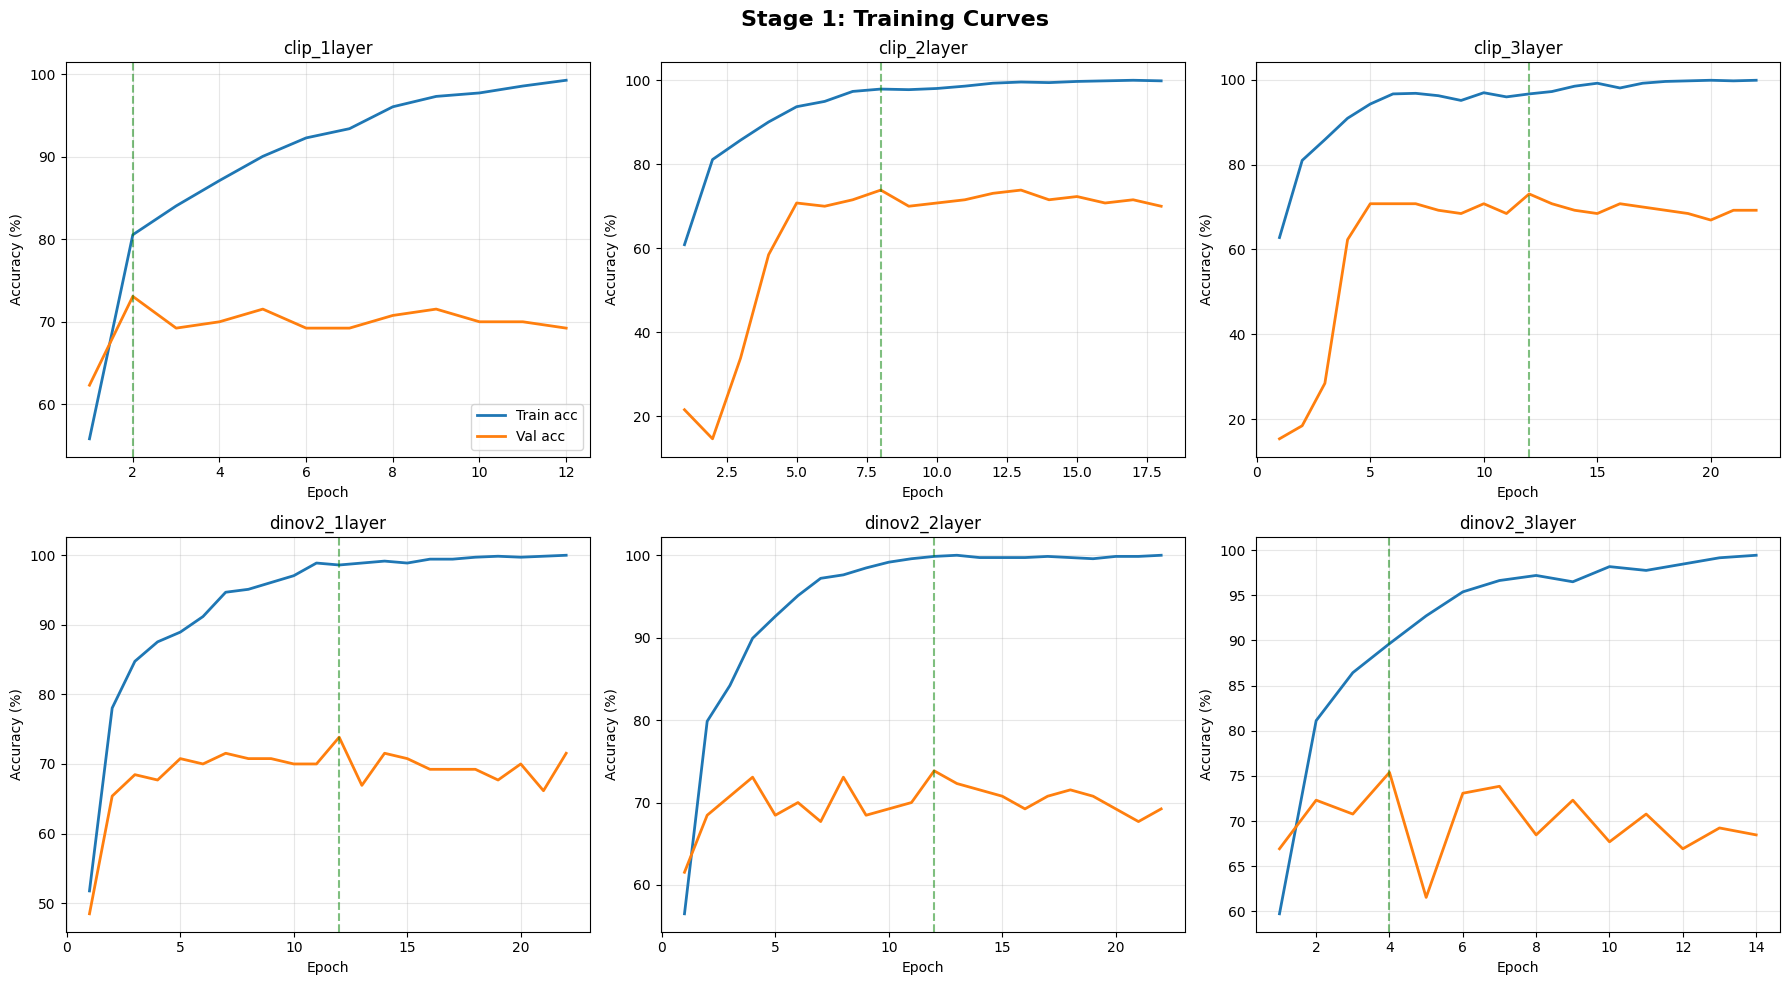

✓ Saved training curves to classification_results/stage1_classifiers/training_curves.png


In [32]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Stage 1: Training Curves', fontsize=16, fontweight='bold')


model_order = ['clip_1layer', 'clip_2layer', 'clip_3layer', 'dinov2_1layer', 'dinov2_2layer', 'dinov2_3layer']


for idx, model_key in enumerate(model_order):
    row, col = divmod(idx, 3)
    ax = axes[row, col]
    history = stage1_results[model_key]
    epochs = range(1, len(history['train_acc']) + 1)


    ax.plot(epochs, history['train_acc'], label='Train acc', color='#1f77b4', linewidth=2)
    ax.plot(epochs, history['val_acc'], label='Val acc', color='#ff7f0e', linewidth=2)


    best_idx = int(np.argmax(history['val_acc']))
    best_acc = history['val_acc'][best_idx]
    ax.axvline(best_idx + 1, color='green', linestyle='--', alpha=0.5)


    ax.set_title(model_key)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.grid(alpha=0.3)
    if idx == 0:
        ax.legend()


plt.tight_layout()
training_curves_path = os.path.join(STAGE1_CONFIG['output_dir'], 'training_curves.png')
plt.savefig(training_curves_path, dpi=150, bbox_inches='tight')
plt.show()


print(f"✓ Saved training curves to {training_curves_path}")

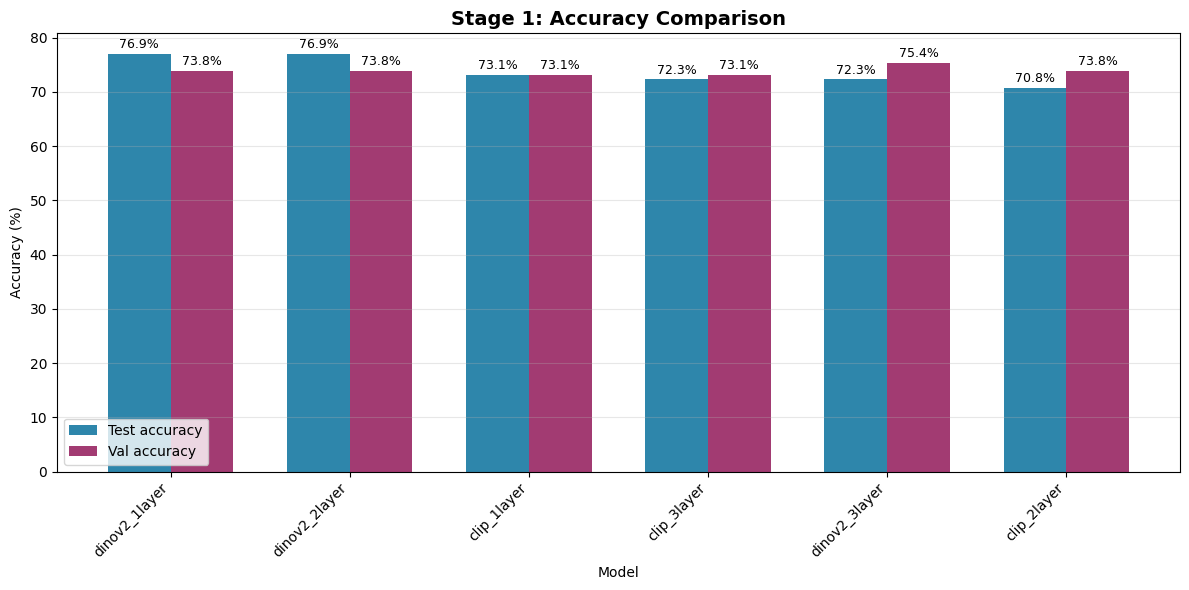

✓ Saved comparison plot to classification_results/stage1_classifiers/model_comparison.png


In [33]:
model_names = [row['Model'] for row in results_summary]
test_accs = [row['Test Accuracy'] for row in results_summary]
val_accs = [row['Val Accuracy'] for row in results_summary]


x = np.arange(len(model_names))
width = 0.35


fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width / 2, test_accs, width, label='Test accuracy', color='#2E86AB')
bars2 = ax.bar(x + width / 2, val_accs, width, label='Val accuracy', color='#A23B72')


ax.set_title('Stage 1: Accuracy Comparison', fontsize=14, fontweight='bold')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)


for bars in (bars1, bars2):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.5, f"{height:.1f}%", ha='center', va='bottom', fontsize=9)


plt.tight_layout()
comparison_path = os.path.join(STAGE1_CONFIG['output_dir'], 'model_comparison.png')
plt.savefig(comparison_path, dpi=150, bbox_inches='tight')
plt.show()


print(f"✓ Saved comparison plot to {comparison_path}")

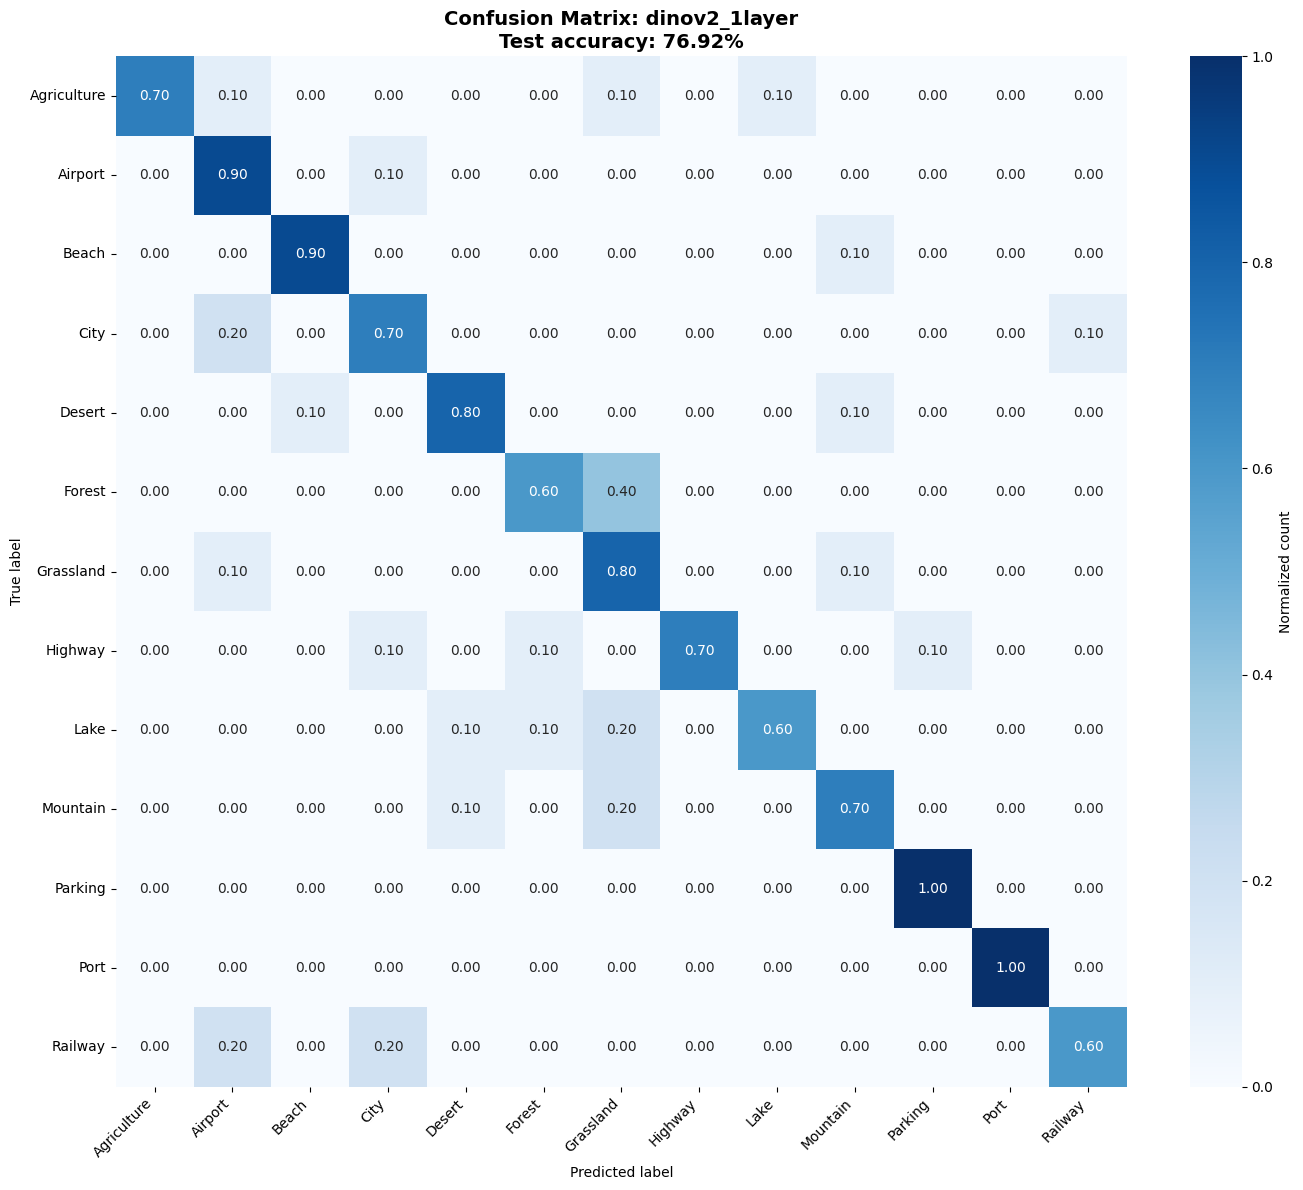

✓ Saved confusion matrix to classification_results/stage1_classifiers/confusion_matrix_dinov2_1layer.png


In [34]:
conf_matrix = best_model_metrics['confusion_matrix']
conf_matrix_norm = conf_matrix.astype(float) / conf_matrix.sum(axis=1, keepdims=True)


plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=classes, yticklabels=classes,
            cbar_kws={'label': 'Normalized count'})


plt.title(f"Confusion Matrix: {best_model_name}\nTest accuracy: {best_model_metrics['accuracy'] * 100:.2f}%", fontsize=14, fontweight='bold')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


conf_mat_path = os.path.join(STAGE1_CONFIG['output_dir'], f'confusion_matrix_{best_model_name}.png')
plt.savefig(conf_mat_path, dpi=150, bbox_inches='tight')
plt.show()


print(f"✓ Saved confusion matrix to {conf_mat_path}")

In [35]:
print("\n" + "=" * 80)
print(f"DETAILED CLASSIFICATION REPORT: {best_model_name}")
print("=" * 80)


print(classification_report(best_model_metrics['labels'],
                          best_model_metrics['predictions'],
                          target_names=classes,
                          digits=4))


class_scores = []
for class_name in classes:
    stats = best_model_metrics['report'][class_name]
    class_scores.append((class_name, stats['f1-score'], stats['support']))


class_scores.sort(key=lambda x: x[1], reverse=True)


print("\nTop 5 classes:")
for idx, (class_name, f1, support) in enumerate(class_scores[:5], 1):
    print(f"  {idx}. {class_name:25s} | F1 {f1:.4f} | support {int(support)}")


print("\nLowest 5 classes:")
for idx, (class_name, f1, support) in enumerate(class_scores[-5:], 1):
    print(f"  {idx}. {class_name:25s} | F1 {f1:.4f} | support {int(support)}")


print("\nStage 1 complete — ready to proceed to Stage 2!")


print("=" * 80)


DETAILED CLASSIFICATION REPORT: dinov2_1layer
              precision    recall  f1-score   support

 Agriculture     1.0000    0.7000    0.8235        10
     Airport     0.6000    0.9000    0.7200        10
       Beach     0.9000    0.9000    0.9000        10
        City     0.6364    0.7000    0.6667        10
      Desert     0.8000    0.8000    0.8000        10
      Forest     0.7500    0.6000    0.6667        10
   Grassland     0.4706    0.8000    0.5926        10
     Highway     1.0000    0.7000    0.8235        10
        Lake     0.8571    0.6000    0.7059        10
    Mountain     0.7000    0.7000    0.7000        10
     Parking     0.9091    1.0000    0.9524        10
        Port     1.0000    1.0000    1.0000        10
     Railway     0.8571    0.6000    0.7059        10

    accuracy                         0.7692       130
   macro avg     0.8062    0.7692    0.7736       130
weighted avg     0.8062    0.7692    0.7736       130


Top 5 classes:
  1. Port       

# Stage 2: Frozen Classifier + Partial Extractor Fine-Tuning

- Lock the best-performing Stage 1 head for each backbone and reuse its weights without gradient updates.
- Unfreeze the lowest three transformer blocks of each backbone to adapt domain-specific low-level features.
- Insert LoRA adapters on the attention projections for both CLIP and DINOv2 to enable efficient adaptation.
- Reuse cached dataset splits and dataloaders; refresh feature caches only if input transforms change.
- Schedule training with discriminative learning rates, mixed precision, and gradient clipping to control stability.
- Track validation accuracy/F1 and early-stop by backbone; store checkpoints and metadata in a new `stage2_classifiers/` folder.

In [36]:
from pathlib import Path
import json

stage1_meta_path = Path("classification_results/stage1_classifiers/stage1_metadata.json")
if not stage1_meta_path.exists():
    raise FileNotFoundError(f"Missing Stage 1 metadata at {stage1_meta_path}")

with stage1_meta_path.open("r", encoding="utf-8") as meta_file:
    stage1_meta = json.load(meta_file)

def _select_best_models(test_accs):
    clip_best = max(((name, acc) for name, acc in test_accs.items() if name.startswith("clip_")), key=lambda item: item[1])
    dino_best = max(((name, acc) for name, acc in test_accs.items() if name.startswith("dinov2_")), key=lambda item: item[1])
    return clip_best, dino_best

clip_best, dino_best = _select_best_models(stage1_meta["test_accuracies"])
print("Selected Stage 1 heads for Stage 2:")
print(f"  CLIP   -> {clip_best[0]} (test acc: {clip_best[1]:.3f})")
print(f"  DINOv2 -> {dino_best[0]} (test acc: {dino_best[1]:.3f})")

Selected Stage 1 heads for Stage 2:
  CLIP   -> clip_1layer (test acc: 0.731)
  DINOv2 -> dinov2_1layer (test acc: 0.769)


In [ ]:
STAGE2_BASE_OUTPUT = "classification_results/stage2_classifiers"

STAGE2_METHOD_CONFIGS = {
    "lora_only": {
        "output_subdir": "lora_only",
        "checkpoint_every": 1,
        "num_epochs": 12,
        "learning_rate": 5e-5,
        "weight_decay": 1e-3,
        "warmup_steps": 50,
        "grad_clip_norm": 1.0,
        "train_batch_size": 16,
        "mixed_precision": False,
        "early_stop_patience": 5,
        "lora": {
            "rank": 8,
            "alpha": 16,
            "dropout": 0.05
        }
    },
    "partial_unfreeze": {
        "output_subdir": "partial_unfreeze",
        "checkpoint_every": 1,
        "num_epochs": 10,
        "learning_rate": 1e-5,
        "weight_decay": 1e-2,
        "warmup_steps": 50,
        "grad_clip_norm": 1.0,
        "train_batch_size": 16,
        "mixed_precision": False,
        "early_stop_patience": 5,
        "trainable_blocks": 3
    }
}

STAGE2_METHOD_CONFIGS

{'lora_only': {'output_subdir': 'lora_only',
  'checkpoint_every': 1,
  'num_epochs': 12,
  'learning_rate': 5e-05,
  'weight_decay': 0.001,
  'warmup_steps': 50,
  'grad_clip_norm': 1.0,
  'train_batch_size': 16,
  'mixed_precision': False,
  'early_stop_patience': 5,
  'lora': {'rank': 3, 'alpha': 16, 'dropout': 0.05}},
 'partial_unfreeze': {'output_subdir': 'partial_unfreeze',
  'checkpoint_every': 1,
  'num_epochs': 10,
  'learning_rate': 1e-05,
  'weight_decay': 0.01,
  'warmup_steps': 50,
  'grad_clip_norm': 1.0,
  'train_batch_size': 16,
  'mixed_precision': False,
  'early_stop_patience': 5,
  'trainable_blocks': 3}}

### Stage 2 TODOs
- Build helper to load Stage 1 heads and freeze parameters while attaching to CLIP/DINOv2 backbones.
- Implement partial unfreezing logic that toggles gradients for the lowest three transformer blocks.
- Integrate PEFT LoRA adapters for the targeted projection layers and prepare optimizer groups.
- Draft the Stage 2 training loop (forward/backward, schedulers, validation hooks, checkpointing).
- Add evaluation + logging parity with Stage 1 (metrics, per-class stats, confusion matrices).
- Update inference pipeline to optionally load Stage 2 fine-tuned backbones.

In [38]:
# Install PEFT for LoRA if not already available
import subprocess
import sys

try:
    import peft
    print("✓ PEFT already installed")
except ImportError:
    print("Installing PEFT...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "peft"])
    import peft
    print("✓ PEFT installed successfully")

print(f"PEFT version: {peft.__version__}")

✓ PEFT already installed
PEFT version: 0.17.1


In [39]:
import math
import copy
import torch
import torch.nn as nn

class FeatureLoRA(nn.Module):
    """Low-rank adapter applied directly to feature vectors."""

    def __init__(self, input_dim: int, rank: int, alpha: int, dropout: float):
        super().__init__()
        self.rank = rank
        self.alpha = alpha
        self.scaling = alpha / rank
        self.lora_A = nn.Linear(input_dim, rank, bias=False)
        self.lora_B = nn.Linear(rank, input_dim, bias=False)
        self.dropout = nn.Dropout(dropout)
        nn.init.kaiming_uniform_(self.lora_A.weight, a=math.sqrt(5))
        nn.init.zeros_(self.lora_B.weight)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.dropout(self.lora_B(self.lora_A(x))) * self.scaling


class Stage2AdapterBase(nn.Module):
    """Common utilities shared by Stage 2 adapters."""

    def __init__(self, stage1_classifier: nn.Module):
        super().__init__()
        self.stage1_classifier = copy.deepcopy(stage1_classifier)
        self._freeze_classifier()

    def _freeze_classifier(self):
        self.stage1_classifier.eval()
        for param in self.stage1_classifier.parameters():
            param.requires_grad = False
        for module in self.stage1_classifier.modules():
            if isinstance(module, nn.BatchNorm1d):
                module.eval()

    def train(self, mode: bool = True):
        super().train(mode)
        # Keep the Stage 1 head frozen regardless of training mode.
        self._freeze_classifier()
        return self


class Stage2CLIPLoRA(Stage2AdapterBase):
    """CLIP backbone frozen with feature-space LoRA adapters."""

    def __init__(self, clip_model, stage1_classifier, feature_dim: int, lora_config: dict):
        super().__init__(stage1_classifier)
        self.backbone = copy.deepcopy(clip_model)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.feature_lora = FeatureLoRA(
            feature_dim,
            rank=lora_config['rank'],
            alpha=lora_config['alpha'],
            dropout=lora_config['dropout']
        )

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        features = self.backbone.get_image_features(pixel_values, output_hidden_states=False)
        adapted = features + self.feature_lora(features)
        return self.stage1_classifier(adapted)


class Stage2CLIPPartial(Stage2AdapterBase):
    """CLIP backbone with bottom transformer blocks unfrozen."""

    def __init__(self, clip_model, stage1_classifier, trainable_blocks: int):
        super().__init__(stage1_classifier)
        self.backbone = copy.deepcopy(clip_model)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self._unfreeze_bottom_blocks(trainable_blocks)

    def _unfreeze_bottom_blocks(self, trainable_blocks: int):
        layers = self.backbone.vision_model.encoder.layers
        n_blocks = min(trainable_blocks, len(layers))
        for idx in range(n_blocks):
            for param in layers[idx].parameters():
                param.requires_grad = True
        print(f"✓ Unfroze bottom {n_blocks} CLIP vision blocks")

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        features = self.backbone.get_image_features(pixel_values, output_hidden_states=False)
        return self.stage1_classifier(features)


class Stage2DINOv2LoRA(Stage2AdapterBase):
    """DINOv2 backbone frozen with feature-space LoRA adapters."""

    def __init__(self, dinov2_model, stage1_classifier, feature_dim: int, lora_config: dict):
        super().__init__(stage1_classifier)
        self.backbone = copy.deepcopy(dinov2_model)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.feature_lora = FeatureLoRA(
            feature_dim,
            rank=lora_config['rank'],
            alpha=lora_config['alpha'],
            dropout=lora_config['dropout']
        )

    def _extract_features(self, pixel_values: torch.Tensor) -> torch.Tensor:
        outputs = self.backbone(pixel_values)
        if isinstance(outputs, dict):
            if 'x_norm_clstoken' in outputs:
                features = outputs['x_norm_clstoken']
            elif 'last_hidden_state' in outputs:
                features = outputs['last_hidden_state'][:, 0]
            else:
                raise ValueError("Unexpected DINOv2 output structure")
        elif isinstance(outputs, (tuple, list)):
            features = outputs[0]
        else:
            features = outputs
        if features.dim() == 3:
            features = features[:, 0, :]
        return features

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        features = self._extract_features(pixel_values)
        adapted = features + self.feature_lora(features)
        return self.stage1_classifier(adapted)


class Stage2DINOv2Partial(Stage2AdapterBase):
    """DINOv2 backbone with bottom transformer blocks unfrozen."""

    def __init__(self, dinov2_model, stage1_classifier, trainable_blocks: int):
        super().__init__(stage1_classifier)
        self.backbone = copy.deepcopy(dinov2_model)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self._unfreeze_bottom_blocks(trainable_blocks)

    def _unfreeze_bottom_blocks(self, trainable_blocks: int):
        blocks = self.backbone.blocks
        n_blocks = min(trainable_blocks, len(blocks))
        for idx in range(n_blocks):
            for param in blocks[idx].parameters():
                param.requires_grad = True
        print(f"✓ Unfroze bottom {n_blocks} DINOv2 transformer blocks")

    def _extract_features(self, pixel_values: torch.Tensor) -> torch.Tensor:
        outputs = self.backbone(pixel_values)
        if isinstance(outputs, dict):
            if 'x_norm_clstoken' in outputs:
                features = outputs['x_norm_clstoken']
            elif 'last_hidden_state' in outputs:
                features = outputs['last_hidden_state'][:, 0]
            else:
                raise ValueError("Unexpected DINOv2 output structure")
        elif isinstance(outputs, (tuple, list)):
            features = outputs[0]
        else:
            features = outputs
        if features.dim() == 3:
            features = features[:, 0, :]
        return features

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        features = self._extract_features(pixel_values)
        return self.stage1_classifier(features)

In [40]:
def load_stage1_classifiers():
    """Load the best Stage 1 classifiers for CLIP and DINOv2"""
    
    stage1_dir = Path("classification_results/stage1_classifiers")
    metadata_path = stage1_dir / "stage1_metadata.json"

    with open(metadata_path, 'r') as f:
        metadata = json.load(f)

    clip_best_name = clip_best[0]
    dino_best_name = dino_best[0]

    print("Loading Stage 1 classifiers:")
    print(f"  CLIP: {clip_best_name}")
    print(f"  DINOv2: {dino_best_name}")

    class MLPClassifier(nn.Module):
        def __init__(self, input_dim, num_classes, hidden_dims, dropout=0.3):
            super().__init__()
            layers = []
            prev_dim = input_dim
            for hidden_dim in hidden_dims:
                layers.append(nn.Linear(prev_dim, hidden_dim))
                layers.append(nn.BatchNorm1d(hidden_dim))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(dropout))
                prev_dim = hidden_dim
            layers.append(nn.Linear(prev_dim, num_classes))
            self.classifier = nn.Sequential(*layers)

        def forward(self, x):
            return self.classifier(x)

    clip_input_dim = metadata['clip_feature_dim']
    clip_hidden_dims = metadata['config']['hidden_dims'][clip_best_name.split('_')[1]]
    clip_classifier = MLPClassifier(
        input_dim=clip_input_dim,
        num_classes=metadata['num_classes'],
        hidden_dims=clip_hidden_dims,
        dropout=metadata['config']['dropout']
    )
    clip_checkpoint_path = stage1_dir / f"{clip_best_name}.pth"
    clip_state = torch.load(clip_checkpoint_path, map_location='cpu')
    clip_classifier.load_state_dict(clip_state['model_state_dict'])
    clip_classifier.eval()
    for module in clip_classifier.modules():
        if isinstance(module, nn.BatchNorm1d):
            module.eval()
    for param in clip_classifier.parameters():
        param.requires_grad = False

    dino_input_dim = metadata['dino_feature_dim']
    dino_hidden_dims = metadata['config']['hidden_dims'][dino_best_name.split('_')[1]]
    dino_classifier = MLPClassifier(
        input_dim=dino_input_dim,
        num_classes=metadata['num_classes'],
        hidden_dims=dino_hidden_dims,
        dropout=metadata['config']['dropout']
    )
    dino_checkpoint_path = stage1_dir / f"{dino_best_name}.pth"
    dino_state = torch.load(dino_checkpoint_path, map_location='cpu')
    dino_classifier.load_state_dict(dino_state['model_state_dict'])
    dino_classifier.eval()
    for module in dino_classifier.modules():
        if isinstance(module, nn.BatchNorm1d):
            module.eval()
    for param in dino_classifier.parameters():
        param.requires_grad = False

    print("✓ Stage 1 classifiers loaded successfully")

    return {
        'clip_classifier': clip_classifier,
        'dino_classifier': dino_classifier,
        'metadata': metadata,
        'clip_model_name': clip_best_name,
        'dino_model_name': dino_best_name
    }

stage1_info = load_stage1_classifiers()

Loading Stage 1 classifiers:
  CLIP: clip_1layer
  DINOv2: dinov2_1layer
✓ Stage 1 classifiers loaded successfully


In [41]:
def create_stage2_models(method_name: str, method_config: dict):
    """Instantiate Stage 2 models for a given adaptation method."""

    metadata = stage1_info['metadata']

    if method_name == "lora_only":
        lora_cfg = method_config['lora']
        stage2_clip = Stage2CLIPLoRA(
            clip_model=clip_model,
            stage1_classifier=stage1_info['clip_classifier'],
            feature_dim=metadata['clip_feature_dim'],
            lora_config=lora_cfg
        ).to(DEVICE)

        stage2_dino = Stage2DINOv2LoRA(
            dinov2_model=dinov2_model,
            stage1_classifier=stage1_info['dino_classifier'],
            feature_dim=metadata['dino_feature_dim'],
            lora_config=lora_cfg
        ).to(DEVICE)

    elif method_name == "partial_unfreeze":
        trainable_blocks = method_config['trainable_blocks']
        stage2_clip = Stage2CLIPPartial(
            clip_model=clip_model,
            stage1_classifier=stage1_info['clip_classifier'],
            trainable_blocks=trainable_blocks
        ).to(DEVICE)

        stage2_dino = Stage2DINOv2Partial(
            dinov2_model=dinov2_model,
            stage1_classifier=stage1_info['dino_classifier'],
            trainable_blocks=trainable_blocks
        ).to(DEVICE)

    else:
        raise ValueError(f"Unknown Stage 2 method: {method_name}")

    clip_trainable = sum(p.numel() for p in stage2_clip.parameters() if p.requires_grad)
    dino_trainable = sum(p.numel() for p in stage2_dino.parameters() if p.requires_grad)

    print(f"✓ Created Stage 2 models for '{method_name}'")
    print(f"  CLIP trainable params: {clip_trainable:,}")
    print(f"  DINOv2 trainable params: {dino_trainable:,}")

    return stage2_clip, stage2_dino

In [42]:
import os
import torch
from torch import nn
from torch.optim.lr_scheduler import LinearLR, CosineAnnealingLR, SequentialLR
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

def build_optimizer_scheduler(model: nn.Module, train_loader, method_config: dict):
    """Create optimizer, scheduler, and scaler for a Stage 2 run."""

    params = [p for p in model.parameters() if p.requires_grad]
    if not params:
        raise ValueError("No trainable parameters found for Stage 2 model.")

    optimizer = torch.optim.AdamW(
        params,
        lr=method_config['learning_rate'],
        weight_decay=method_config['weight_decay']
    )

    total_steps = len(train_loader) * method_config['num_epochs']
    warmup_iters = min(method_config['warmup_steps'], max(total_steps, 1))

    warmup = LinearLR(optimizer, start_factor=0.1, total_iters=warmup_iters)
    cosine = CosineAnnealingLR(optimizer, T_max=max(total_steps - warmup_iters, 1))
    scheduler = SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_iters])

    scaler = GradScaler() if method_config.get('mixed_precision', False) else None

    return optimizer, scheduler, scaler, total_steps

In [43]:
def train_stage2_model(model, method_name, model_name, train_loader, val_loader, optimizer, scheduler, scaler, method_config, output_dir):
    """Generic Stage 2 training loop used by both CLIP and DINO backbones."""

    os.makedirs(output_dir, exist_ok=True)

    print(f"\n{'=' * 60}")
    print(f"Training Stage 2 ({method_name}): {model_name}")
    print(f"{'=' * 60}")

    criterion = nn.CrossEntropyLoss()
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'learning_rates': []}

    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0

    for epoch in range(method_config['num_epochs']):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{method_config['num_epochs']}")

        for batch_idx, (images, labels) in enumerate(progress_bar):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            if method_config.get('mixed_precision', False) and scaler:
                with autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                scaler.scale(loss).backward()

                if method_config.get('grad_clip_norm'):
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), method_config['grad_clip_norm'])

                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()

                if method_config.get('grad_clip_norm'):
                    torch.nn.utils.clip_grad_norm_(model.parameters(), method_config['grad_clip_norm'])

                optimizer.step()

            if scheduler:
                scheduler.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

            current_lr = optimizer.param_groups[0]['lr']
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100. * train_correct / train_total:.2f}%',
                'LR': f'{current_lr:.2e}'
            })

        train_loss /= len(train_loader)
        train_acc = 100. * train_correct / train_total
        current_lr = optimizer.param_groups[0]['lr']

        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(DEVICE), labels.to(DEVICE)

                if method_config.get('mixed_precision', False) and scaler:
                    with autocast():
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                else:
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100. * val_correct / val_total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['learning_rates'].append(current_lr)

        print(f"Epoch {epoch + 1:3d}: Train Loss {train_loss:.4f} | Train Acc {train_acc:6.2f}% | "
              f"Val Loss {val_loss:.4f} | Val Acc {val_acc:6.2f}% | LR {current_lr:.2e}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            patience_counter = 0

            if (epoch + 1) % method_config.get('checkpoint_every', 1) == 0:
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                    'best_val_acc': best_val_acc,
                    'history': history,
                    'method_name': method_name
                }
                if scaler:
                    checkpoint['scaler_state_dict'] = scaler.state_dict()

                checkpoint_path = os.path.join(output_dir, f'{model_name}_best.pth')
                torch.save(checkpoint, checkpoint_path)
        else:
            patience_counter += 1
            if patience_counter >= method_config.get('early_stop_patience', 5):
                print(f"Early stopping at epoch {epoch + 1} (best val acc: {best_val_acc:.2f}% at epoch {best_epoch + 1})")
                break

    print(f"\n✓ {model_name} training complete!")
    print(f"  Best validation accuracy: {best_val_acc:.2f}% (epoch {best_epoch + 1})")

    return model, history, best_val_acc

stage2_training_results = {}

# Ensure we are working with the original frozen backbones, not prior Stage 2 wrappers
if hasattr(clip_model, 'backbone'):
    clip_model = clip_model.backbone
if hasattr(dinov2_model, 'backbone'):
    dinov2_model = dinov2_model.backbone

clip_model = clip_model.to(DEVICE).eval()
dinov2_model = dinov2_model.to(DEVICE).eval()

for method_name, method_config in STAGE2_METHOD_CONFIGS.items():
    method_output_dir = os.path.join(STAGE2_BASE_OUTPUT, method_config['output_subdir'])
    os.makedirs(method_output_dir, exist_ok=True)

    clip_stage2_model, dino_stage2_model = create_stage2_models(method_name, method_config)

    clip_optimizer, clip_scheduler, clip_scaler, _ = build_optimizer_scheduler(
        model=clip_stage2_model,
        train_loader=train_loader_clip,
        method_config=method_config
    )
    dino_optimizer, dino_scheduler, dino_scaler, _ = build_optimizer_scheduler(
        model=dino_stage2_model,
        train_loader=train_loader_dino,
        method_config=method_config
    )

    trained_clip, clip_history, clip_best = train_stage2_model(
        model=clip_stage2_model,
        method_name=method_name,
        model_name=f'{method_name}_clip',
        train_loader=train_loader_clip,
        val_loader=val_loader_clip,
        optimizer=clip_optimizer,
        scheduler=clip_scheduler,
        scaler=clip_scaler,
        method_config=method_config,
        output_dir=method_output_dir
    )

    trained_clip_cpu = trained_clip.to('cpu')
    del clip_stage2_model
    torch.cuda.empty_cache()

    trained_dino, dino_history, dino_best = train_stage2_model(
        model=dino_stage2_model,
        method_name=method_name,
        model_name=f'{method_name}_dino',
        train_loader=train_loader_dino,
        val_loader=val_loader_dino,
        optimizer=dino_optimizer,
        scheduler=dino_scheduler,
        scaler=dino_scaler,
        method_config=method_config,
        output_dir=method_output_dir
    )

    trained_dino_cpu = trained_dino.to('cpu')
    del dino_stage2_model
    torch.cuda.empty_cache()

    stage2_training_results[method_name] = {
        'clip': {
            'model': trained_clip_cpu,
            'history': clip_history,
            'best_val_acc': clip_best,
            'output_dir': method_output_dir
        },
        'dino': {
            'model': trained_dino_cpu,
            'history': dino_history,
            'best_val_acc': dino_best,
            'output_dir': method_output_dir
        }
    }

✓ Created Stage 2 models for 'lora_only'
  CLIP trainable params: 3,072
  DINOv2 trainable params: 2,304

Training Stage 2 (lora_only): lora_only_clip


Epoch 1/12: 100%|██████████| 23/23 [00:07<00:00,  2.94it/s, Loss=10.4963, Acc=65.73%, LR=2.57e-05]



Epoch   1: Train Loss 9.0798 | Train Acc  65.73% | Val Loss 24.0821 | Val Acc  56.92% | LR 2.57e-05


Epoch 2/12: 100%|██████████| 23/23 [00:07<00:00,  3.00it/s, Loss=1.3628, Acc=66.85%, LR=4.64e-05] 



Epoch   2: Train Loss 8.1416 | Train Acc  66.85% | Val Loss 23.2197 | Val Acc  57.69% | LR 4.64e-05


Epoch 3/12: 100%|██████████| 23/23 [00:07<00:00,  3.07it/s, Loss=2.6308, Acc=70.21%, LR=4.91e-05] 



Epoch   3: Train Loss 6.8537 | Train Acc  70.21% | Val Loss 20.9967 | Val Acc  61.54% | LR 4.91e-05


Epoch 4/12: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s, Loss=3.1354, Acc=74.97%, LR=4.59e-05]



Epoch   4: Train Loss 5.1645 | Train Acc  74.97% | Val Loss 18.1122 | Val Acc  64.62% | LR 4.59e-05


Epoch 5/12: 100%|██████████| 23/23 [00:08<00:00,  2.79it/s, Loss=0.3229, Acc=78.18%, LR=4.05e-05]



Epoch   5: Train Loss 4.2653 | Train Acc  78.18% | Val Loss 15.6772 | Val Acc  66.92% | LR 4.05e-05


Epoch 6/12: 100%|██████████| 23/23 [00:08<00:00,  2.73it/s, Loss=2.5002, Acc=82.10%, LR=3.35e-05]



Epoch   6: Train Loss 3.0760 | Train Acc  82.10% | Val Loss 14.0714 | Val Acc  68.46% | LR 3.35e-05


Epoch 7/12: 100%|██████████| 23/23 [00:09<00:00,  2.52it/s, Loss=1.9074, Acc=84.76%, LR=2.57e-05]



Epoch   7: Train Loss 2.3717 | Train Acc  84.76% | Val Loss 12.8504 | Val Acc  68.46% | LR 2.57e-05


Epoch 8/12: 100%|██████████| 23/23 [00:08<00:00,  2.75it/s, Loss=1.7669, Acc=84.34%, LR=1.78e-05]



Epoch   8: Train Loss 2.4010 | Train Acc  84.34% | Val Loss 12.2875 | Val Acc  68.46% | LR 1.78e-05


Epoch 9/12: 100%|██████████| 23/23 [00:07<00:00,  2.99it/s, Loss=6.5425, Acc=85.17%, LR=1.06e-05]



Epoch   9: Train Loss 2.6229 | Train Acc  85.17% | Val Loss 11.9365 | Val Acc  69.23% | LR 1.06e-05


Epoch 10/12: 100%|██████████| 23/23 [00:09<00:00,  2.34it/s, Loss=1.3293, Acc=84.90%, LR=4.94e-06]



Epoch  10: Train Loss 2.1637 | Train Acc  84.90% | Val Loss 11.7522 | Val Acc  69.23% | LR 4.94e-06


Epoch 11/12: 100%|██████████| 23/23 [00:08<00:00,  2.66it/s, Loss=0.6562, Acc=85.03%, LR=1.27e-06]



Epoch  11: Train Loss 1.9689 | Train Acc  85.03% | Val Loss 11.6990 | Val Acc  69.23% | LR 1.27e-06


Epoch 12/12: 100%|██████████| 23/23 [00:08<00:00,  2.84it/s, Loss=0.0000, Acc=86.01%, LR=0.00e+00]



Epoch  12: Train Loss 2.2204 | Train Acc  86.01% | Val Loss 11.6888 | Val Acc  69.23% | LR 0.00e+00

✓ lora_only_clip training complete!
  Best validation accuracy: 69.23% (epoch 9)

Training Stage 2 (lora_only): lora_only_dino

Training Stage 2 (lora_only): lora_only_dino


Epoch 1/12: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s, Loss=0.6003, Acc=94.41%, LR=2.57e-05]



Epoch   1: Train Loss 0.1957 | Train Acc  94.41% | Val Loss 1.1170 | Val Acc  71.54% | LR 2.57e-05


Epoch 2/12: 100%|██████████| 23/23 [00:09<00:00,  2.48it/s, Loss=0.2961, Acc=94.27%, LR=4.64e-05]



Epoch   2: Train Loss 0.1840 | Train Acc  94.27% | Val Loss 1.1151 | Val Acc  71.54% | LR 4.64e-05


Epoch 3/12: 100%|██████████| 23/23 [00:09<00:00,  2.36it/s, Loss=0.1527, Acc=94.69%, LR=4.91e-05]



Epoch   3: Train Loss 0.1943 | Train Acc  94.69% | Val Loss 1.1117 | Val Acc  71.54% | LR 4.91e-05


Epoch 4/12: 100%|██████████| 23/23 [00:08<00:00,  2.83it/s, Loss=0.1205, Acc=93.57%, LR=4.59e-05]



Epoch   4: Train Loss 0.1826 | Train Acc  93.57% | Val Loss 1.1107 | Val Acc  71.54% | LR 4.59e-05


Epoch 5/12: 100%|██████████| 23/23 [00:08<00:00,  2.71it/s, Loss=0.2264, Acc=94.41%, LR=4.05e-05]



Epoch   5: Train Loss 0.1849 | Train Acc  94.41% | Val Loss 1.1144 | Val Acc  71.54% | LR 4.05e-05


Epoch 6/12: 100%|██████████| 23/23 [00:08<00:00,  2.72it/s, Loss=0.1658, Acc=94.83%, LR=3.35e-05]



Epoch   6: Train Loss 0.1648 | Train Acc  94.83% | Val Loss 1.1172 | Val Acc  71.54% | LR 3.35e-05
Early stopping at epoch 6 (best val acc: 71.54% at epoch 1)

✓ lora_only_dino training complete!
  Best validation accuracy: 71.54% (epoch 1)
✓ Unfroze bottom 3 CLIP vision blocks
✓ Unfroze bottom 3 DINOv2 transformer blocks
✓ Created Stage 2 models for 'partial_unfreeze'
  CLIP trainable params: 21,263,616
  DINOv2 trainable params: 5,325,696

Training Stage 2 (partial_unfreeze): partial_unfreeze_clip


Epoch 1/10: 100%|██████████| 23/23 [00:09<00:00,  2.39it/s, Loss=1.2903, Acc=70.07%, LR=5.14e-06] 



Epoch   1: Train Loss 6.6780 | Train Acc  70.07% | Val Loss 20.5785 | Val Acc  58.46% | LR 5.14e-06


Epoch 2/10: 100%|██████████| 23/23 [00:10<00:00,  2.18it/s, Loss=1.8013, Acc=79.72%, LR=9.28e-06]



Epoch   2: Train Loss 3.4042 | Train Acc  79.72% | Val Loss 14.3991 | Val Acc  67.69% | LR 9.28e-06


Epoch 3/10: 100%|██████████| 23/23 [00:10<00:00,  2.13it/s, Loss=4.3554, Acc=86.01%, LR=9.73e-06]


Epoch   3: Train Loss 2.0074 | Train Acc  86.01% | Val Loss 12.2648 | Val Acc  66.15% | LR 9.73e-06


Epoch 4/10: 100%|██████████| 23/23 [00:08<00:00,  2.67it/s, Loss=2.5419, Acc=86.57%, LR=8.72e-06]



Epoch   4: Train Loss 1.6983 | Train Acc  86.57% | Val Loss 10.9819 | Val Acc  66.92% | LR 8.72e-06


Epoch 5/10: 100%|██████████| 23/23 [00:09<00:00,  2.42it/s, Loss=0.8816, Acc=86.85%, LR=7.11e-06]



Epoch   5: Train Loss 1.3875 | Train Acc  86.85% | Val Loss 11.0002 | Val Acc  67.69% | LR 7.11e-06


Epoch 6/10: 100%|██████████| 23/23 [00:08<00:00,  2.65it/s, Loss=3.6762, Acc=86.43%, LR=5.17e-06]



Epoch   6: Train Loss 1.6382 | Train Acc  86.43% | Val Loss 10.5065 | Val Acc  68.46% | LR 5.17e-06


Epoch 7/10: 100%|██████████| 23/23 [00:09<00:00,  2.46it/s, Loss=1.3925, Acc=87.55%, LR=3.21e-06]



Epoch   7: Train Loss 1.2161 | Train Acc  87.55% | Val Loss 9.8777 | Val Acc  67.69% | LR 3.21e-06


Epoch 8/10: 100%|██████████| 23/23 [00:10<00:00,  2.27it/s, Loss=0.4329, Acc=87.69%, LR=1.53e-06]



Epoch   8: Train Loss 1.1169 | Train Acc  87.69% | Val Loss 10.0661 | Val Acc  68.46% | LR 1.53e-06


Epoch 9/10: 100%|██████████| 23/23 [00:08<00:00,  2.58it/s, Loss=1.6698, Acc=88.95%, LR=3.97e-07]



Epoch   9: Train Loss 1.0951 | Train Acc  88.95% | Val Loss 10.0236 | Val Acc  68.46% | LR 3.97e-07


Epoch 10/10: 100%|██████████| 23/23 [00:09<00:00,  2.33it/s, Loss=0.5790, Acc=89.79%, LR=0.00e+00]



Epoch  10: Train Loss 1.0822 | Train Acc  89.79% | Val Loss 9.9347 | Val Acc  68.46% | LR 0.00e+00

✓ partial_unfreeze_clip training complete!
  Best validation accuracy: 68.46% (epoch 6)

Training Stage 2 (partial_unfreeze): partial_unfreeze_dino

Training Stage 2 (partial_unfreeze): partial_unfreeze_dino


Epoch 1/10: 100%|██████████| 23/23 [00:10<00:00,  2.23it/s, Loss=0.2153, Acc=94.69%, LR=5.14e-06]



Epoch   1: Train Loss 0.1894 | Train Acc  94.69% | Val Loss 1.2088 | Val Acc  70.77% | LR 5.14e-06


Epoch 2/10: 100%|██████████| 23/23 [00:10<00:00,  2.19it/s, Loss=0.0630, Acc=95.24%, LR=9.28e-06]



Epoch   2: Train Loss 0.1717 | Train Acc  95.24% | Val Loss 1.3020 | Val Acc  70.00% | LR 9.28e-06


Epoch 3/10: 100%|██████████| 23/23 [00:10<00:00,  2.10it/s, Loss=0.0698, Acc=95.94%, LR=9.73e-06]



Epoch   3: Train Loss 0.1490 | Train Acc  95.94% | Val Loss 1.1859 | Val Acc  70.77% | LR 9.73e-06


Epoch 4/10: 100%|██████████| 23/23 [00:10<00:00,  2.17it/s, Loss=0.0473, Acc=95.10%, LR=8.72e-06]



Epoch   4: Train Loss 0.1519 | Train Acc  95.10% | Val Loss 1.2336 | Val Acc  70.77% | LR 8.72e-06


Epoch 5/10: 100%|██████████| 23/23 [00:11<00:00,  2.05it/s, Loss=0.0240, Acc=95.24%, LR=7.11e-06]



Epoch   5: Train Loss 0.1405 | Train Acc  95.24% | Val Loss 1.2533 | Val Acc  70.00% | LR 7.11e-06


Epoch 6/10: 100%|██████████| 23/23 [00:11<00:00,  2.02it/s, Loss=0.1058, Acc=96.50%, LR=5.17e-06]



Epoch   6: Train Loss 0.1222 | Train Acc  96.50% | Val Loss 1.2165 | Val Acc  70.77% | LR 5.17e-06
Early stopping at epoch 6 (best val acc: 70.77% at epoch 1)

✓ partial_unfreeze_dino training complete!
  Best validation accuracy: 70.77% (epoch 1)


In [80]:
import json
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def _json_safe(obj):
    if isinstance(obj, dict):
        return {k: _json_safe(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [_json_safe(v) for v in obj]
    if isinstance(obj, (np.ndarray, torch.Tensor)):
        return _json_safe(obj.tolist())
    if isinstance(obj, (np.floating, np.float32, np.float64)):
        return float(obj)
    if isinstance(obj, (np.integer, np.int32, np.int64)):
        return int(obj)
    return obj

def evaluate_stage2_backbone(model: nn.Module, loader):
    model = model.to(DEVICE)
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for images, targets in loader:
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)
            logits = model(images)
            batch_preds = torch.argmax(logits, dim=1)
            preds.append(batch_preds.cpu())
            labels.append(targets.cpu())

    preds = torch.cat(preds)
    labels = torch.cat(labels)

    accuracy = accuracy_score(labels.numpy(), preds.numpy())
    report_dict = classification_report(
        labels.numpy(), preds.numpy(), target_names=classes, output_dict=True
    )
    conf_mat = confusion_matrix(labels.numpy(), preds.numpy())

    model = model.to('cpu')
    torch.cuda.empty_cache()

    return accuracy, report_dict, conf_mat

stage2_test_results = {}

for method_name, method_outputs in stage2_training_results.items():
    method_config = STAGE2_METHOD_CONFIGS[method_name]
    method_results = {}

    for backbone_name, backbone_info in method_outputs.items():
        model = backbone_info['model']
        output_dir = backbone_info['output_dir']
        checkpoint_path = os.path.join(
            output_dir, f"{method_name}_{backbone_name}_best.pth"
        )

        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location='cpu')
            model.load_state_dict(checkpoint['model_state_dict'])
        else:
            print(f"Warning: checkpoint not found at {checkpoint_path}. Using in-memory weights.")

        data_loader = test_loader_clip if backbone_name == 'clip' else test_loader_dino

        test_acc, report, conf_mat = evaluate_stage2_backbone(model, data_loader)

        metrics_payload = {
            'method': method_name,
            'backbone': backbone_name,
            'best_val_acc': backbone_info['best_val_acc'],
            'test_accuracy': test_acc,
            'classification_report': _json_safe(report),
            'confusion_matrix': conf_mat.tolist(),
            'num_test_samples': len(data_loader.dataset)
        }

        metrics_path = os.path.join(
            output_dir, f"{method_name}_{backbone_name}_metrics.json"
        )
        with open(metrics_path, 'w') as f:
            json.dump(metrics_payload, f, indent=2)

        np.save(
            os.path.join(output_dir, f"{method_name}_{backbone_name}_confusion.npy"),
            conf_mat
        )

        method_results[backbone_name] = metrics_payload

        print(
            f"✓ {method_name}/{backbone_name} test accuracy: {test_acc * 100:.2f}% "
            f"(best val {backbone_info['best_val_acc']:.2f}%)"
        )

    stage2_test_results[method_name] = method_results

print("\nStage 2 testing complete. Metrics saved alongside checkpoints.")

✓ lora_only/clip test accuracy: 86.00% (best val 89.33%)
✓ lora_only/dino test accuracy: 92.33% (best val 90.00%)
✓ partial_unfreeze/clip test accuracy: 91.67% (best val 90.33%)
✓ partial_unfreeze/dino test accuracy: 92.00% (best val 91.67%)

Stage 2 testing complete. Metrics saved alongside checkpoints.
